# Classical Link Prediction
In this notebook we will show how to run, starting from the embeddings previously obtained, a classical link prediction with experimental setup as close as possible to Leskovec et al and Yue et al.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## Retrieving the embeddings
We will run the link prediction for each one of the embedding that we have previously obtained:

- CBOW
- SkipGram
- BinarySkipGram
- GloVe


## Edge embeddings
We will compute the edge embeddings using all the 5 available methods:

- Hadamart: an element-wise product
- Mean
- Norm L1
- Norm L2
- Concatenation

## Defining a simple Feed Forward Neural Network

In [2]:
import os

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC, Recall, Precision

def build_link_prediction_model(input_shape:int):
    model = Sequential([
        Input(input_shape),
        Dense(256, activation="relu"),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss="binary_crossentropy",
        optimizer="nadam",
        metrics=[
            AUC(curve="PR", name="auprc"),
            AUC(curve="ROC", name="auroc"),
            Recall(),
            Precision(),
            "accuracy"
        ]
    )
    return model

## Loading the graph
As done previously, we are going to load the graph.

In [4]:
from ensmallen_graph import EnsmallenGraph

graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
)

## Defining holdouts and tasks data generator
We are going to create the same edge embeddings as in the training of the embeddings.

In [5]:
seed = 42
train_percentage = 0.8

pos_training, pos_validation = graph.connected_holdout(seed=seed, train_percentage=train_percentage)
neg_training, neg_validation = graph.sample_negatives(
    seed=seed,
    negatives_number=graph.get_edges_number(),
    allow_selfloops=False
).random_holdout(seed=seed, train_percentage=train_percentage)

In [6]:
from tqdm.auto import tqdm
from glob import glob
from embiggen import GraphTransformer, EdgeTransformer
import numpy as np
import pandas as pd

def task_generator(
    pos_training:EnsmallenGraph,
    pos_validation:EnsmallenGraph,
    neg_training:EnsmallenGraph,
    neg_validation:EnsmallenGraph,
    train_percentage:float=0.8,
    seed:int=42
):
    """Create new generator of tasks.
    
    Parameters
    ----------------------------------
    pos_training:EnsmallenGraph,
        The positive edges of the training graph.
    pos_validation:EnsmallenGraph,
        The positive edges of the validation graph.
    neg_training:EnsmallenGraph,
        The negative edges of the training graph.
    neg_validation:EnsmallenGraph,
        The negative edges of the validation graph.
    train_percentage:float=0.8,
    seed:int=42
    
    """
    for path in tqdm(glob("*embedding.npy"), desc="Embedding"):
        model_name = path.split("_")[0]
        embedding = np.load(path)
        for method in tqdm(EdgeTransformer.methods, desc="Methods", leave=False):
            transformer = GraphTransformer(method)
            transformer.fit(embedding)
            train_edges = np.vstack([
                transformer.transform(graph)
                for graph in (pos_training, neg_training)
            ])
            valid_edges = np.vstack([
                transformer.transform(graph)
                for graph in (pos_validation, neg_validation)
            ])
            train_labels = np.concatenate([
                np.ones(pos_training.get_edges_number()),
                np.zeros(neg_training.get_edges_number())
            ])
            valid_labels = np.concatenate([
                np.ones(pos_validation.get_edges_number()),
                np.zeros(neg_validation.get_edges_number())
            ])
            train_indices = np.arange(0, train_labels.size)
            valid_indices = np.arange(0, valid_labels.size)
            np.random.shuffle(train_indices)
            np.random.shuffle(valid_indices)
            train_edges = train_edges[train_indices]
            train_labels = train_labels[train_indices]
            valid_edges = valid_edges[valid_indices]
            valid_labels = valid_labels[valid_indices]
            yield model_name, method, (train_edges, train_labels), (valid_edges, valid_labels)

## Training the models

In [7]:
from tensorflow.distribute import MirroredStrategy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


histories = {}
strategy = MirroredStrategy()
os.makedirs("classical_link_prediction", exist_ok=True)

for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
    history_path = f"classical_link_prediction/{embedding_model}_{method}.csv"
    if os.path.exists(history_path):
        histories[(embedding_model, method)] = pd.read_csv(history_path)
        continue
    with strategy.scope():
        model = build_link_prediction_model(train[0].shape[1:])
    history = pd.DataFrame(model.fit(
        *train,
        batch_size=2**12,
        validation_data=valid,
        epochs=1000,
        callbacks=[
            EarlyStopping("val_loss", patience=20, min_delta=0.0001),
            ReduceLROnPlateau()
        ]
    ).history)

    history.to_csv(history_path, index=False)
    histories[(embedding_model, method)] = history
    

Epoch 1/1000
230/230 [==============================] - 6s 26ms/step - accuracy: 0.6235 - auprc: 0.6882 - precision: 0.6327 - recall: 0.5886 - loss: 0.6380 - auroc: 0.6778 - val_accuracy: 0.6790 - val_auprc: 0.7589 - val_precision: 0.6959 - val_recall: 0.6360 - val_loss: 0.5858 - val_auroc: 0.7503 - lr: 0.0010
Epoch 2/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.6807 - auprc: 0.7568 - precision: 0.6926 - recall: 0.6499 - loss: 0.5815 - auroc: 0.7556 - val_accuracy: 0.6995 - val_auprc: 0.7853 - val_precision: 0.6716 - val_recall: 0.7808 - val_loss: 0.5569 - val_auroc: 0.7855 - lr: 0.0010
Epoch 3/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7043 - auprc: 0.7820 - precision: 0.7072 - recall: 0.6974 - loss: 0.5524 - auroc: 0.7861 - val_accuracy: 0.7144 - val_auprc: 0.8035 - val_precision: 0.6764 - val_recall: 0.8222 - val_loss: 0.5368 - val_auroc: 0.8067 - lr: 0.0010
Epoch 4/1000
230/230 [==============================] - 3s 13ms/

230/230 [==============================] - 3s 13ms/step - accuracy: 0.8063 - auprc: 0.8828 - precision: 0.7970 - recall: 0.8221 - loss: 0.4098 - auroc: 0.8922 - val_accuracy: 0.8004 - val_auprc: 0.8792 - val_precision: 0.7809 - val_recall: 0.8352 - val_loss: 0.4205 - val_auroc: 0.8872 - lr: 0.0010
Epoch 28/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8074 - auprc: 0.8836 - precision: 0.7981 - recall: 0.8231 - loss: 0.4084 - auroc: 0.8931 - val_accuracy: 0.7997 - val_auprc: 0.8784 - val_precision: 0.7685 - val_recall: 0.8579 - val_loss: 0.4238 - val_auroc: 0.8869 - lr: 0.0010
Epoch 29/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8090 - auprc: 0.8850 - precision: 0.7991 - recall: 0.8256 - loss: 0.4059 - auroc: 0.8945 - val_accuracy: 0.8015 - val_auprc: 0.8803 - val_precision: 0.7739 - val_recall: 0.8518 - val_loss: 0.4191 - val_auroc: 0.8886 - lr: 0.0010
Epoch 30/1000
230/230 [==============================] - 3s 13ms/step - acc

230/230 [==============================] - 3s 13ms/step - accuracy: 0.8318 - auprc: 0.9048 - precision: 0.8219 - recall: 0.8471 - loss: 0.3697 - auroc: 0.9134 - val_accuracy: 0.8133 - val_auprc: 0.8903 - val_precision: 0.7866 - val_recall: 0.8598 - val_loss: 0.4025 - val_auroc: 0.8987 - lr: 0.0010
Epoch 54/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8329 - auprc: 0.9055 - precision: 0.8233 - recall: 0.8477 - loss: 0.3681 - auroc: 0.9142 - val_accuracy: 0.8137 - val_auprc: 0.8892 - val_precision: 0.7969 - val_recall: 0.8421 - val_loss: 0.4041 - val_auroc: 0.8977 - lr: 0.0010
Epoch 55/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8326 - auprc: 0.9057 - precision: 0.8230 - recall: 0.8475 - loss: 0.3680 - auroc: 0.9143 - val_accuracy: 0.8150 - val_auprc: 0.8903 - val_precision: 0.8085 - val_recall: 0.8255 - val_loss: 0.4059 - val_auroc: 0.8984 - lr: 0.0010
Epoch 56/1000
230/230 [==============================] - 3s 13ms/step - acc

230/230 [==============================] - 3s 13ms/step - accuracy: 0.8430 - auprc: 0.9140 - precision: 0.8341 - recall: 0.8564 - loss: 0.3511 - auroc: 0.9222 - val_accuracy: 0.8197 - val_auprc: 0.8931 - val_precision: 0.8115 - val_recall: 0.8328 - val_loss: 0.4019 - val_auroc: 0.9017 - lr: 0.0010
Epoch 80/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8493 - auprc: 0.9181 - precision: 0.8407 - recall: 0.8618 - loss: 0.3415 - auroc: 0.9266 - val_accuracy: 0.8215 - val_auprc: 0.8944 - val_precision: 0.8013 - val_recall: 0.8552 - val_loss: 0.3976 - val_auroc: 0.9032 - lr: 1.0000e-04
Epoch 81/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8499 - auprc: 0.9186 - precision: 0.8412 - recall: 0.8626 - loss: 0.3406 - auroc: 0.9270 - val_accuracy: 0.8210 - val_auprc: 0.8943 - val_precision: 0.8089 - val_recall: 0.8405 - val_loss: 0.3993 - val_auroc: 0.9030 - lr: 1.0000e-04
Epoch 82/1000
230/230 [==============================] - 3s 13ms/st

Epoch 5/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7158 - precision_1: 0.7255 - auprc: 0.8008 - recall_1: 0.6944 - loss: 0.5375 - auroc: 0.8000 - val_accuracy: 0.7310 - val_precision_1: 0.7314 - val_auprc: 0.8178 - val_recall_1: 0.7299 - val_loss: 0.5191 - val_auroc: 0.8190 - lr: 0.0010
Epoch 6/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7254 - precision_1: 0.7337 - auprc: 0.8107 - recall_1: 0.7075 - loss: 0.5254 - auroc: 0.8110 - val_accuracy: 0.7341 - val_precision_1: 0.7509 - val_auprc: 0.8232 - val_recall_1: 0.7006 - val_loss: 0.5108 - val_auroc: 0.8233 - lr: 0.0010
Epoch 7/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7334 - precision_1: 0.7411 - auprc: 0.8187 - recall_1: 0.7175 - loss: 0.5151 - auroc: 0.8200 - val_accuracy: 0.7454 - val_precision_1: 0.7526 - val_auprc: 0.8326 - val_recall_1: 0.7310 - val_loss: 0.4967 - val_auroc: 0.8344 - lr: 0.0010
Epoch 8/1000
230/230 [==================

Epoch 31/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7974 - precision_1: 0.8036 - auprc: 0.8818 - recall_1: 0.7871 - loss: 0.4222 - auroc: 0.8860 - val_accuracy: 0.7984 - val_precision_1: 0.8080 - val_auprc: 0.8815 - val_recall_1: 0.7827 - val_loss: 0.4255 - val_auroc: 0.8858 - lr: 0.0010
Epoch 32/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7985 - precision_1: 0.8049 - auprc: 0.8831 - recall_1: 0.7879 - loss: 0.4200 - auroc: 0.8873 - val_accuracy: 0.7989 - val_precision_1: 0.7763 - val_auprc: 0.8814 - val_recall_1: 0.8398 - val_loss: 0.4265 - val_auroc: 0.8864 - lr: 0.0010
Epoch 33/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7993 - precision_1: 0.8053 - auprc: 0.8836 - recall_1: 0.7895 - loss: 0.4190 - auroc: 0.8878 - val_accuracy: 0.8002 - val_precision_1: 0.8103 - val_auprc: 0.8831 - val_recall_1: 0.7838 - val_loss: 0.4213 - val_auroc: 0.8875 - lr: 0.0010
Epoch 34/1000
230/230 [==============

230/230 [==============================] - 3s 12ms/step - accuracy: 0.8167 - precision_1: 0.8240 - auprc: 0.8990 - recall_1: 0.8054 - loss: 0.3899 - auroc: 0.9039 - val_accuracy: 0.8102 - val_precision_1: 0.8182 - val_auprc: 0.8912 - val_recall_1: 0.7977 - val_loss: 0.4082 - val_auroc: 0.8965 - lr: 0.0010
Epoch 57/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8166 - precision_1: 0.8242 - auprc: 0.8990 - recall_1: 0.8048 - loss: 0.3898 - auroc: 0.9039 - val_accuracy: 0.8109 - val_precision_1: 0.8136 - val_auprc: 0.8911 - val_recall_1: 0.8067 - val_loss: 0.4065 - val_auroc: 0.8966 - lr: 0.0010
Epoch 58/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8170 - precision_1: 0.8238 - auprc: 0.8993 - recall_1: 0.8066 - loss: 0.3894 - auroc: 0.9042 - val_accuracy: 0.8090 - val_precision_1: 0.8183 - val_auprc: 0.8906 - val_recall_1: 0.7943 - val_loss: 0.4093 - val_auroc: 0.8960 - lr: 0.0010
Epoch 59/1000
230/230 [============================

Epoch 82/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8252 - precision_1: 0.8344 - auprc: 0.9063 - recall_1: 0.8114 - loss: 0.3748 - auroc: 0.9115 - val_accuracy: 0.8129 - val_precision_1: 0.8193 - val_auprc: 0.8920 - val_recall_1: 0.8029 - val_loss: 0.4050 - val_auroc: 0.8983 - lr: 0.0010
Epoch 83/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8256 - precision_1: 0.8352 - auprc: 0.9069 - recall_1: 0.8113 - loss: 0.3741 - auroc: 0.9119 - val_accuracy: 0.8145 - val_precision_1: 0.8100 - val_auprc: 0.8924 - val_recall_1: 0.8217 - val_loss: 0.4048 - val_auroc: 0.8988 - lr: 0.0010
Epoch 84/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8251 - precision_1: 0.8344 - auprc: 0.9066 - recall_1: 0.8113 - loss: 0.3741 - auroc: 0.9118 - val_accuracy: 0.8143 - val_precision_1: 0.8073 - val_auprc: 0.8930 - val_recall_1: 0.8258 - val_loss: 0.4035 - val_auroc: 0.8991 - lr: 0.0010
Epoch 85/1000
230/230 [==============

230/230 [==============================] - 3s 12ms/step - accuracy: 0.7221 - precision_2: 0.7018 - auprc: 0.7719 - recall_2: 0.7726 - loss: 0.5419 - auroc: 0.7969 - val_accuracy: 0.7320 - val_precision_2: 0.7151 - val_auprc: 0.7818 - val_recall_2: 0.7712 - val_loss: 0.5290 - val_auroc: 0.8069 - lr: 0.0010
Epoch 3/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7326 - precision_2: 0.7071 - auprc: 0.7820 - recall_2: 0.7943 - loss: 0.5278 - auroc: 0.8081 - val_accuracy: 0.7389 - val_precision_2: 0.7241 - val_auprc: 0.7884 - val_recall_2: 0.7721 - val_loss: 0.5202 - val_auroc: 0.8144 - lr: 0.0010
Epoch 4/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7395 - precision_2: 0.7108 - auprc: 0.7885 - recall_2: 0.8076 - loss: 0.5185 - auroc: 0.8153 - val_accuracy: 0.7379 - val_precision_2: 0.7465 - val_auprc: 0.7931 - val_recall_2: 0.7204 - val_loss: 0.5221 - val_auroc: 0.8189 - lr: 0.0010
Epoch 5/1000
230/230 [==============================]

Epoch 28/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7925 - precision_2: 0.7597 - auprc: 0.8514 - recall_2: 0.8554 - loss: 0.4387 - auroc: 0.8726 - val_accuracy: 0.7643 - val_precision_2: 0.7508 - val_auprc: 0.8199 - val_recall_2: 0.7912 - val_loss: 0.4901 - val_auroc: 0.8436 - lr: 0.0010
Epoch 29/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7926 - precision_2: 0.7598 - auprc: 0.8522 - recall_2: 0.8559 - loss: 0.4378 - auroc: 0.8731 - val_accuracy: 0.7671 - val_precision_2: 0.7368 - val_auprc: 0.8201 - val_recall_2: 0.8310 - val_loss: 0.4826 - val_auroc: 0.8442 - lr: 0.0010
Epoch 30/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7942 - precision_2: 0.7615 - auprc: 0.8539 - recall_2: 0.8567 - loss: 0.4354 - auroc: 0.8746 - val_accuracy: 0.7667 - val_precision_2: 0.7475 - val_auprc: 0.8208 - val_recall_2: 0.8053 - val_loss: 0.4889 - val_auroc: 0.8446 - lr: 0.0010
Epoch 31/1000
230/230 [==============

230/230 [==============================] - 3s 13ms/step - accuracy: 0.7387 - auprc: 0.7912 - precision_3: 0.7100 - recall_3: 0.8071 - loss: 0.5190 - auroc: 0.8152 - val_accuracy: 0.7386 - val_auprc: 0.7931 - val_precision_3: 0.7355 - val_recall_3: 0.7454 - val_loss: 0.5210 - val_auroc: 0.8169 - lr: 0.0010
Epoch 5/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7445 - auprc: 0.7973 - precision_3: 0.7141 - recall_3: 0.8153 - loss: 0.5110 - auroc: 0.8215 - val_accuracy: 0.7430 - val_auprc: 0.7974 - val_precision_3: 0.6972 - val_recall_3: 0.8591 - val_loss: 0.5132 - val_auroc: 0.8216 - lr: 0.0010
Epoch 6/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7485 - auprc: 0.8018 - precision_3: 0.7170 - recall_3: 0.8210 - loss: 0.5049 - auroc: 0.8262 - val_accuracy: 0.7496 - val_auprc: 0.8014 - val_precision_3: 0.7204 - val_recall_3: 0.8158 - val_loss: 0.5063 - val_auroc: 0.8253 - lr: 0.0010
Epoch 7/1000
230/230 [==============================]

Epoch 30/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7931 - auprc: 0.8539 - precision_3: 0.7583 - recall_3: 0.8604 - loss: 0.4372 - auroc: 0.8737 - val_accuracy: 0.7672 - val_auprc: 0.8226 - val_precision_3: 0.7360 - val_recall_3: 0.8332 - val_loss: 0.4848 - val_auroc: 0.8453 - lr: 0.0010
Epoch 31/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7941 - auprc: 0.8550 - precision_3: 0.7590 - recall_3: 0.8618 - loss: 0.4356 - auroc: 0.8747 - val_accuracy: 0.7686 - val_auprc: 0.8231 - val_precision_3: 0.7478 - val_recall_3: 0.8107 - val_loss: 0.4848 - val_auroc: 0.8461 - lr: 0.0010
Epoch 32/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7950 - auprc: 0.8562 - precision_3: 0.7599 - recall_3: 0.8624 - loss: 0.4342 - auroc: 0.8757 - val_accuracy: 0.7653 - val_auprc: 0.8209 - val_precision_3: 0.7199 - val_recall_3: 0.8687 - val_loss: 0.4848 - val_auroc: 0.8446 - lr: 0.0010
Epoch 33/1000
230/230 [==============

230/230 [==============================] - 3s 13ms/step - accuracy: 0.4995 - auprc: 0.5001 - precision_4: 0.4997 - loss: 0.6931 - recall_4: 0.8426 - auroc: 0.5000 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_precision_4: 0.5000 - val_loss: 0.6931 - val_recall_4: 1.0000 - val_auroc: 0.5000 - lr: 1.0000e-04
Epoch 14/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.4994 - auprc: 0.4999 - precision_4: 0.4996 - loss: 0.6931 - recall_4: 0.8111 - auroc: 0.5000 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_precision_4: 0.5000 - val_loss: 0.6931 - val_recall_4: 1.0000 - val_auroc: 0.5000 - lr: 1.0000e-04
Epoch 15/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.4994 - auprc: 0.5000 - precision_4: 0.4990 - loss: 0.6931 - recall_4: 0.2833 - auroc: 0.5000 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_precision_4: 0.5000 - val_loss: 0.6931 - val_recall_4: 1.0000 - val_auroc: 0.5000 - lr: 1.0000e-04
Epoch 16/1000
230/230 [================

Epoch 1/1000
230/230 [==============================] - 6s 25ms/step - accuracy: 0.8150 - auprc: 0.8904 - recall_5: 0.8169 - loss: 0.4277 - precision_5: 0.8138 - auroc: 0.8912 - val_accuracy: 0.8039 - val_auprc: 0.8863 - val_recall_5: 0.7488 - val_loss: 0.4508 - val_precision_5: 0.8415 - val_auroc: 0.8807 - lr: 0.0010
Epoch 2/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8537 - auprc: 0.9239 - recall_5: 0.8436 - loss: 0.3523 - precision_5: 0.8609 - auroc: 0.9254 - val_accuracy: 0.8120 - val_auprc: 0.8951 - val_recall_5: 0.7548 - val_loss: 0.4328 - val_precision_5: 0.8523 - val_auroc: 0.8902 - lr: 0.0010
Epoch 3/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8629 - auprc: 0.9317 - recall_5: 0.8547 - loss: 0.3318 - precision_5: 0.8689 - auroc: 0.9333 - val_accuracy: 0.8186 - val_auprc: 0.9011 - val_recall_5: 0.7646 - val_loss: 0.4222 - val_precision_5: 0.8573 - val_auroc: 0.8967 - lr: 0.0010
Epoch 4/1000
230/230 [==================

Epoch 27/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9012 - auprc: 0.9619 - recall_5: 0.8960 - loss: 0.2445 - precision_5: 0.9053 - auroc: 0.9632 - val_accuracy: 0.8318 - val_auprc: 0.9101 - val_recall_5: 0.7653 - val_loss: 0.4159 - val_precision_5: 0.8827 - val_auroc: 0.9077 - lr: 0.0010
Epoch 28/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9014 - auprc: 0.9622 - recall_5: 0.8962 - loss: 0.2436 - precision_5: 0.9056 - auroc: 0.9635 - val_accuracy: 0.8331 - val_auprc: 0.9086 - val_recall_5: 0.7717 - val_loss: 0.4128 - val_precision_5: 0.8796 - val_auroc: 0.9068 - lr: 0.0010
Epoch 29/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9026 - auprc: 0.9626 - recall_5: 0.8970 - loss: 0.2419 - precision_5: 0.9071 - auroc: 0.9639 - val_accuracy: 0.8307 - val_auprc: 0.9074 - val_recall_5: 0.7596 - val_loss: 0.4218 - val_precision_5: 0.8855 - val_auroc: 0.9065 - lr: 0.0010
Epoch 30/1000
230/230 [==============

230/230 [==============================] - 3s 12ms/step - precision_6: 0.8624 - accuracy: 0.8711 - auprc: 0.9357 - loss: 0.3087 - recall_6: 0.8830 - auroc: 0.9416 - val_precision_6: 0.8572 - val_accuracy: 0.8685 - val_auprc: 0.9305 - val_loss: 0.3251 - val_recall_6: 0.8842 - val_auroc: 0.9369 - lr: 0.0010
Epoch 13/1000
230/230 [==============================] - 3s 12ms/step - precision_6: 0.8635 - accuracy: 0.8727 - auprc: 0.9370 - loss: 0.3053 - recall_6: 0.8853 - auroc: 0.9428 - val_precision_6: 0.8781 - val_accuracy: 0.8699 - val_auprc: 0.9334 - val_loss: 0.3222 - val_recall_6: 0.8591 - val_auroc: 0.9389 - lr: 0.0010
Epoch 14/1000
230/230 [==============================] - 3s 12ms/step - precision_6: 0.8658 - accuracy: 0.8752 - auprc: 0.9387 - loss: 0.3004 - recall_6: 0.8882 - auroc: 0.9446 - val_precision_6: 0.8803 - val_accuracy: 0.8704 - val_auprc: 0.9330 - val_loss: 0.3221 - val_recall_6: 0.8575 - val_auroc: 0.9389 - lr: 0.0010
Epoch 15/1000
230/230 [============================

230/230 [==============================] - 3s 13ms/step - precision_6: 0.8875 - accuracy: 0.8986 - auprc: 0.9567 - loss: 0.2495 - recall_6: 0.9130 - auroc: 0.9613 - val_precision_6: 0.8861 - val_accuracy: 0.8748 - val_auprc: 0.9344 - val_loss: 0.3214 - val_recall_6: 0.8600 - val_auroc: 0.9411 - lr: 1.0000e-04
Epoch 38/1000
230/230 [==============================] - 3s 13ms/step - precision_6: 0.8879 - accuracy: 0.8991 - auprc: 0.9570 - loss: 0.2488 - recall_6: 0.9136 - auroc: 0.9615 - val_precision_6: 0.8865 - val_accuracy: 0.8743 - val_auprc: 0.9342 - val_loss: 0.3224 - val_recall_6: 0.8584 - val_auroc: 0.9410 - lr: 1.0000e-04
Epoch 39/1000
230/230 [==============================] - 3s 13ms/step - precision_6: 0.8881 - accuracy: 0.8991 - auprc: 0.9572 - loss: 0.2483 - recall_6: 0.9133 - auroc: 0.9617 - val_precision_6: 0.8863 - val_accuracy: 0.8744 - val_auprc: 0.9337 - val_loss: 0.3232 - val_recall_6: 0.8589 - val_auroc: 0.9407 - lr: 1.0000e-04
Epoch 40/1000
230/230 [================

230/230 [==============================] - 3s 13ms/step - accuracy: 0.8053 - auprc: 0.8908 - precision_7: 0.8164 - loss: 0.4164 - recall_7: 0.7876 - auroc: 0.8900 - val_accuracy: 0.7821 - val_auprc: 0.8719 - val_precision_7: 0.7854 - val_loss: 0.4518 - val_recall_7: 0.7764 - val_auroc: 0.8693 - lr: 0.0010
Epoch 20/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8068 - auprc: 0.8920 - precision_7: 0.8165 - loss: 0.4138 - recall_7: 0.7915 - auroc: 0.8915 - val_accuracy: 0.7839 - val_auprc: 0.8730 - val_precision_7: 0.8149 - val_loss: 0.4515 - val_recall_7: 0.7347 - val_auroc: 0.8698 - lr: 0.0010
Epoch 21/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8077 - auprc: 0.8930 - precision_7: 0.8170 - loss: 0.4119 - recall_7: 0.7930 - auroc: 0.8925 - val_accuracy: 0.7849 - val_auprc: 0.8735 - val_precision_7: 0.7940 - val_loss: 0.4483 - val_recall_7: 0.7693 - val_auroc: 0.8709 - lr: 0.0010
Epoch 22/1000
230/230 [============================

230/230 [==============================] - 3s 12ms/step - accuracy: 0.6579 - auprc: 0.6840 - recall_8: 0.7685 - loss: 0.6377 - precision_8: 0.6293 - auroc: 0.7020 - val_accuracy: 0.6925 - val_auprc: 0.7739 - val_recall_8: 0.7655 - val_loss: 0.6069 - val_precision_8: 0.6680 - val_auroc: 0.7745 - lr: 0.0010
Epoch 4/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.6757 - auprc: 0.7219 - recall_8: 0.7772 - loss: 0.6019 - precision_8: 0.6461 - auroc: 0.7286 - val_accuracy: 0.7040 - val_auprc: 0.7948 - val_recall_8: 0.8065 - val_loss: 0.5673 - val_precision_8: 0.6693 - val_auroc: 0.7941 - lr: 0.0010
Epoch 5/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.6904 - auprc: 0.7394 - recall_8: 0.7793 - loss: 0.5832 - precision_8: 0.6616 - auroc: 0.7461 - val_accuracy: 0.7303 - val_auprc: 0.8159 - val_recall_8: 0.7157 - val_loss: 0.5440 - val_precision_8: 0.7372 - val_auroc: 0.8074 - lr: 0.0010
Epoch 6/1000
230/230 [==============================]

Epoch 29/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.7991 - auprc: 0.8806 - recall_8: 0.8352 - loss: 0.4238 - precision_8: 0.7789 - auroc: 0.8838 - val_accuracy: 0.7772 - val_auprc: 0.8626 - val_recall_8: 0.8157 - val_loss: 0.4639 - val_precision_8: 0.7574 - val_auroc: 0.8626 - lr: 0.0010
Epoch 30/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8005 - auprc: 0.8821 - recall_8: 0.8367 - loss: 0.4213 - precision_8: 0.7802 - auroc: 0.8853 - val_accuracy: 0.7760 - val_auprc: 0.8619 - val_recall_8: 0.8210 - val_loss: 0.4662 - val_precision_8: 0.7533 - val_auroc: 0.8623 - lr: 0.0010
Epoch 31/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8019 - auprc: 0.8834 - recall_8: 0.8364 - loss: 0.4195 - precision_8: 0.7824 - auroc: 0.8866 - val_accuracy: 0.7755 - val_auprc: 0.8618 - val_recall_8: 0.8194 - val_loss: 0.4664 - val_precision_8: 0.7532 - val_auroc: 0.8619 - lr: 0.0010
Epoch 32/1000
230/230 [==============

230/230 [==============================] - 3s 13ms/step - accuracy: 0.8214 - auprc: 0.8984 - recall_8: 0.8558 - loss: 0.3891 - precision_8: 0.8008 - auroc: 0.9036 - val_accuracy: 0.7794 - val_auprc: 0.8675 - val_recall_8: 0.8297 - val_loss: 0.4629 - val_precision_8: 0.7539 - val_auroc: 0.8663 - lr: 0.0010
Epoch 55/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8219 - auprc: 0.8988 - recall_8: 0.8558 - loss: 0.3886 - precision_8: 0.8015 - auroc: 0.9038 - val_accuracy: 0.7802 - val_auprc: 0.8669 - val_recall_8: 0.8228 - val_loss: 0.4631 - val_precision_8: 0.7581 - val_auroc: 0.8654 - lr: 0.0010
Epoch 56/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.8222 - auprc: 0.8990 - recall_8: 0.8550 - loss: 0.3876 - precision_8: 0.8023 - auroc: 0.9042 - val_accuracy: 0.7801 - val_auprc: 0.8674 - val_recall_8: 0.8225 - val_loss: 0.4636 - val_precision_8: 0.7582 - val_auroc: 0.8656 - lr: 0.0010
Epoch 57/1000
230/230 [============================

230/230 [==============================] - 3s 13ms/step - accuracy: 0.4994 - auprc: 0.4999 - loss: 0.6932 - recall_9: 0.6986 - auroc: 0.4998 - precision_9: 0.4996 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_loss: 0.6932 - val_recall_9: 2.0382e-04 - val_auroc: 0.5000 - val_precision_9: 0.5000 - lr: 0.0010
Epoch 12/1000
230/230 [==============================] - 3s 13ms/step - accuracy: 0.5001 - auprc: 0.5002 - loss: 0.6932 - recall_9: 0.1764 - auroc: 0.5001 - precision_9: 0.5003 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_loss: 0.6931 - val_recall_9: 3.7367e-04 - val_auroc: 0.5000 - val_precision_9: 0.5000 - lr: 1.0000e-04
Epoch 13/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.5002 - auprc: 0.5004 - loss: 0.6931 - recall_9: 0.2113 - auroc: 0.5002 - precision_9: 0.5004 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_loss: 0.6931 - val_recall_9: 2.0382e-04 - val_auroc: 0.5000 - val_precision_9: 0.5000 - lr: 1.0000e-04
Epoch 14/1000
230/230 [========

Epoch 1/1000
230/230 [==============================] - 5s 21ms/step - accuracy: 0.6140 - auprc: 0.6891 - precision_10: 0.6178 - loss: 0.6389 - recall_10: 0.5977 - auroc: 0.6704 - val_accuracy: 0.6790 - val_auprc: 0.7691 - val_precision_10: 0.7324 - val_loss: 0.5883 - val_recall_10: 0.5640 - val_auroc: 0.7468 - lr: 0.0010
Epoch 2/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.6876 - auprc: 0.7733 - precision_10: 0.7146 - loss: 0.5777 - recall_10: 0.6247 - auroc: 0.7602 - val_accuracy: 0.7020 - val_auprc: 0.7968 - val_precision_10: 0.7156 - val_loss: 0.5588 - val_recall_10: 0.6706 - val_auroc: 0.7773 - lr: 0.0010
Epoch 3/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7150 - auprc: 0.8032 - precision_10: 0.7396 - loss: 0.5477 - recall_10: 0.6638 - auroc: 0.7922 - val_accuracy: 0.7144 - val_auprc: 0.8101 - val_precision_10: 0.7422 - val_loss: 0.5435 - val_recall_10: 0.6570 - val_auroc: 0.7923 - lr: 0.0010
Epoch 4/1000
230/230 [======

230/230 [==============================] - 3s 12ms/step - accuracy: 0.8010 - auprc: 0.8894 - precision_10: 0.8201 - loss: 0.4265 - recall_10: 0.7712 - auroc: 0.8843 - val_accuracy: 0.7437 - val_auprc: 0.8372 - val_precision_10: 0.7684 - val_loss: 0.5197 - val_recall_10: 0.6978 - val_auroc: 0.8247 - lr: 1.0000e-04
Epoch 27/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8009 - auprc: 0.8898 - precision_10: 0.8197 - loss: 0.4259 - recall_10: 0.7715 - auroc: 0.8847 - val_accuracy: 0.7431 - val_auprc: 0.8365 - val_precision_10: 0.7704 - val_loss: 0.5220 - val_recall_10: 0.6926 - val_auroc: 0.8241 - lr: 1.0000e-04
Epoch 28/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.8018 - auprc: 0.8902 - precision_10: 0.8211 - loss: 0.4252 - recall_10: 0.7717 - auroc: 0.8851 - val_accuracy: 0.7435 - val_auprc: 0.8368 - val_precision_10: 0.7699 - val_loss: 0.5212 - val_recall_10: 0.6945 - val_auroc: 0.8244 - lr: 1.0000e-04
Epoch 29/1000
230/230 [====

230/230 [==============================] - 3s 13ms/step - recall_11: 0.9056 - accuracy: 0.8775 - auprc: 0.9474 - precision_11: 0.8574 - loss: 0.2875 - auroc: 0.9497 - val_recall_11: 0.7954 - val_accuracy: 0.8329 - val_auprc: 0.9199 - val_precision_11: 0.8599 - val_loss: 0.3908 - val_auroc: 0.9192 - lr: 0.0010
Epoch 20/1000
230/230 [==============================] - 3s 12ms/step - recall_11: 0.9070 - accuracy: 0.8788 - auprc: 0.9484 - precision_11: 0.8587 - loss: 0.2848 - auroc: 0.9506 - val_recall_11: 0.8255 - val_accuracy: 0.8376 - val_auprc: 0.9210 - val_precision_11: 0.8460 - val_loss: 0.3750 - val_auroc: 0.9206 - lr: 0.0010
Epoch 21/1000
230/230 [==============================] - 3s 12ms/step - recall_11: 0.9085 - accuracy: 0.8804 - auprc: 0.9489 - precision_11: 0.8601 - loss: 0.2830 - auroc: 0.9512 - val_recall_11: 0.8167 - val_accuracy: 0.8369 - val_auprc: 0.9212 - val_precision_11: 0.8510 - val_loss: 0.3786 - val_auroc: 0.9209 - lr: 0.0010
Epoch 22/1000
230/230 [================

230/230 [==============================] - 3s 12ms/step - accuracy: 0.6821 - auprc: 0.7487 - recall_12: 0.6853 - precision_12: 0.6810 - loss: 0.5862 - auroc: 0.7514 - val_accuracy: 0.6478 - val_auprc: 0.6965 - val_recall_12: 0.6860 - val_precision_12: 0.6373 - val_loss: 0.6256 - val_auroc: 0.7044 - lr: 0.0010
Epoch 13/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.6853 - auprc: 0.7524 - recall_12: 0.6858 - precision_12: 0.6851 - loss: 0.5827 - auroc: 0.7554 - val_accuracy: 0.6481 - val_auprc: 0.6984 - val_recall_12: 0.6304 - val_precision_12: 0.6536 - val_loss: 0.6261 - val_auroc: 0.7059 - lr: 0.0010
Epoch 14/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.6884 - auprc: 0.7562 - recall_12: 0.6857 - precision_12: 0.6895 - loss: 0.5793 - auroc: 0.7593 - val_accuracy: 0.6429 - val_auprc: 0.6998 - val_recall_12: 0.5514 - val_precision_12: 0.6749 - val_loss: 0.6360 - val_auroc: 0.7063 - lr: 0.0010
Epoch 15/1000
230/230 [================

230/230 [==============================] - 3s 12ms/step - accuracy: 0.7203 - auprc: 0.7978 - recall_12: 0.6954 - precision_12: 0.7319 - loss: 0.5386 - auroc: 0.8007 - val_accuracy: 0.6503 - val_auprc: 0.7000 - val_recall_12: 0.6257 - val_precision_12: 0.6580 - val_loss: 0.6322 - val_auroc: 0.7099 - lr: 1.0000e-04
Epoch 38/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7205 - auprc: 0.7984 - recall_12: 0.6958 - precision_12: 0.7320 - loss: 0.5380 - auroc: 0.8013 - val_accuracy: 0.6502 - val_auprc: 0.6996 - val_recall_12: 0.6231 - val_precision_12: 0.6588 - val_loss: 0.6329 - val_auroc: 0.7094 - lr: 1.0000e-04
Epoch 39/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.7210 - auprc: 0.7981 - recall_12: 0.6962 - precision_12: 0.7325 - loss: 0.5383 - auroc: 0.8011 - val_accuracy: 0.6496 - val_auprc: 0.6992 - val_recall_12: 0.6192 - val_precision_12: 0.6593 - val_loss: 0.6330 - val_auroc: 0.7092 - lr: 1.0000e-04
Epoch 1/1000
230/230 [=====

230/230 [==============================] - 3s 12ms/step - recall_13: 0.6924 - accuracy: 0.7153 - auprc: 0.7946 - precision_13: 0.7256 - loss: 0.5442 - auroc: 0.7946 - val_recall_13: 0.6619 - val_accuracy: 0.6595 - val_auprc: 0.7087 - val_precision_13: 0.6587 - val_loss: 0.6157 - val_auroc: 0.7198 - lr: 0.0010
Epoch 24/1000
230/230 [==============================] - 3s 12ms/step - recall_13: 0.6994 - accuracy: 0.7222 - auprc: 0.8027 - precision_13: 0.7327 - loss: 0.5358 - auroc: 0.8026 - val_recall_13: 0.6328 - val_accuracy: 0.6592 - val_auprc: 0.7109 - val_precision_13: 0.6680 - val_loss: 0.6174 - val_auroc: 0.7213 - lr: 1.0000e-04
Epoch 25/1000
230/230 [==============================] - 3s 12ms/step - recall_13: 0.6990 - accuracy: 0.7239 - auprc: 0.8043 - precision_13: 0.7357 - loss: 0.5340 - auroc: 0.8040 - val_recall_13: 0.6361 - val_accuracy: 0.6600 - val_auprc: 0.7107 - val_precision_13: 0.6680 - val_loss: 0.6182 - val_auroc: 0.7213 - lr: 1.0000e-04
Epoch 26/1000
230/230 [========

230/230 [==============================] - 3s 12ms/step - accuracy: 0.5001 - auprc: 0.5001 - recall_14: 0.0209 - loss: 0.6931 - auroc: 0.5000 - precision_14: 0.5024 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_recall_14: 0.0332 - val_loss: 0.6931 - val_auroc: 0.5000 - val_precision_14: 0.5000 - lr: 1.0000e-04
Epoch 16/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.5001 - auprc: 0.5000 - recall_14: 0.2153 - loss: 0.6931 - auroc: 0.5000 - precision_14: 0.5003 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_recall_14: 0.9689 - val_loss: 0.6931 - val_auroc: 0.5000 - val_precision_14: 0.5000 - lr: 1.0000e-04
Epoch 17/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.4993 - auprc: 0.5000 - recall_14: 0.7795 - loss: 0.6931 - auroc: 0.5000 - precision_14: 0.4996 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_recall_14: 0.9689 - val_loss: 0.6931 - val_auroc: 0.5000 - val_precision_14: 0.5000 - lr: 1.0000e-04
Epoch 18/1000
230/230 [====

Epoch 1/1000
230/230 [==============================] - 6s 25ms/step - accuracy: 0.8789 - precision_15: 0.8759 - auprc: 0.9426 - recall_15: 0.8828 - loss: 0.3014 - auroc: 0.9471 - val_accuracy: 0.9036 - val_precision_15: 0.9155 - val_auprc: 0.9561 - val_recall_15: 0.8893 - val_loss: 0.2672 - val_auroc: 0.9580 - lr: 0.0010
Epoch 2/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9250 - precision_15: 0.9162 - auprc: 0.9673 - recall_15: 0.9354 - loss: 0.2062 - auroc: 0.9722 - val_accuracy: 0.9102 - val_precision_15: 0.9100 - val_auprc: 0.9604 - val_recall_15: 0.9106 - val_loss: 0.2561 - val_auroc: 0.9620 - lr: 0.0010
Epoch 3/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9288 - precision_15: 0.9205 - auprc: 0.9706 - recall_15: 0.9386 - loss: 0.1940 - auroc: 0.9752 - val_accuracy: 0.9124 - val_precision_15: 0.9010 - val_auprc: 0.9626 - val_recall_15: 0.9265 - val_loss: 0.2512 - val_auroc: 0.9641 - lr: 0.0010
Epoch 4/1000
230/230 [======

230/230 [==============================] - 3s 13ms/step - accuracy: 0.9480 - precision_15: 0.9440 - auprc: 0.9816 - recall_15: 0.9525 - loss: 0.1473 - auroc: 0.9846 - val_accuracy: 0.9224 - val_precision_15: 0.9354 - val_auprc: 0.9679 - val_recall_15: 0.9075 - val_loss: 0.2416 - val_auroc: 0.9689 - lr: 1.0000e-04
Epoch 27/1000
230/230 [==============================] - 3s 14ms/step - accuracy: 0.9480 - precision_15: 0.9441 - auprc: 0.9815 - recall_15: 0.9525 - loss: 0.1473 - auroc: 0.9846 - val_accuracy: 0.9225 - val_precision_15: 0.9354 - val_auprc: 0.9679 - val_recall_15: 0.9077 - val_loss: 0.2397 - val_auroc: 0.9690 - lr: 1.0000e-04
Epoch 28/1000
230/230 [==============================] - 3s 14ms/step - accuracy: 0.9482 - precision_15: 0.9442 - auprc: 0.9815 - recall_15: 0.9527 - loss: 0.1469 - auroc: 0.9847 - val_accuracy: 0.9226 - val_precision_15: 0.9353 - val_auprc: 0.9679 - val_recall_15: 0.9080 - val_loss: 0.2408 - val_auroc: 0.9689 - lr: 1.0000e-04
Epoch 29/1000
230/230 [====

230/230 [==============================] - 3s 12ms/step - accuracy: 0.9495 - auprc: 0.9799 - precision_16: 0.9413 - loss: 0.1457 - auroc: 0.9842 - recall_16: 0.9587 - val_accuracy: 0.9257 - val_auprc: 0.9651 - val_precision_16: 0.9120 - val_loss: 0.2296 - val_auroc: 0.9695 - val_recall_16: 0.9423 - lr: 0.0010
Epoch 22/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9494 - auprc: 0.9802 - precision_16: 0.9411 - loss: 0.1452 - auroc: 0.9843 - recall_16: 0.9587 - val_accuracy: 0.9265 - val_auprc: 0.9654 - val_precision_16: 0.9183 - val_loss: 0.2263 - val_auroc: 0.9696 - val_recall_16: 0.9363 - lr: 0.0010
Epoch 23/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9501 - auprc: 0.9803 - precision_16: 0.9420 - loss: 0.1438 - auroc: 0.9845 - recall_16: 0.9592 - val_accuracy: 0.9265 - val_auprc: 0.9655 - val_precision_16: 0.9284 - val_loss: 0.2294 - val_auroc: 0.9694 - val_recall_16: 0.9243 - lr: 0.0010
Epoch 24/1000
230/230 [================

230/230 [==============================] - 3s 13ms/step - accuracy: 0.9224 - auprc: 0.9630 - recall_17: 0.9348 - loss: 0.2087 - auroc: 0.9711 - precision_17: 0.9123 - val_accuracy: 0.9026 - val_auprc: 0.9557 - val_recall_17: 0.8813 - val_loss: 0.2729 - val_auroc: 0.9596 - val_precision_17: 0.9206 - lr: 0.0010
Epoch 10/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9237 - auprc: 0.9639 - recall_17: 0.9362 - loss: 0.2057 - auroc: 0.9718 - precision_17: 0.9133 - val_accuracy: 0.9035 - val_auprc: 0.9560 - val_recall_17: 0.9222 - val_loss: 0.2576 - val_auroc: 0.9602 - val_precision_17: 0.8890 - lr: 0.0010
Epoch 11/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9247 - auprc: 0.9645 - recall_17: 0.9375 - loss: 0.2028 - auroc: 0.9725 - precision_17: 0.9141 - val_accuracy: 0.9053 - val_auprc: 0.9563 - val_recall_17: 0.9144 - val_loss: 0.2610 - val_auroc: 0.9603 - val_precision_17: 0.8981 - lr: 0.0010
Epoch 12/1000
230/230 [================

230/230 [==============================] - 3s 12ms/step - accuracy: 0.9187 - auprc: 0.9602 - precision_18: 0.9080 - loss: 0.2180 - recall_18: 0.9318 - auroc: 0.9687 - val_accuracy: 0.9030 - val_auprc: 0.9539 - val_precision_18: 0.8989 - val_loss: 0.2641 - val_recall_18: 0.9082 - val_auroc: 0.9586 - lr: 0.0010
Epoch 5/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9210 - auprc: 0.9620 - precision_18: 0.9094 - loss: 0.2121 - recall_18: 0.9352 - auroc: 0.9701 - val_accuracy: 0.9047 - val_auprc: 0.9549 - val_precision_18: 0.9045 - val_loss: 0.2630 - val_recall_18: 0.9049 - val_auroc: 0.9594 - lr: 0.0010
Epoch 6/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.9224 - auprc: 0.9630 - precision_18: 0.9101 - loss: 0.2083 - recall_18: 0.9374 - auroc: 0.9711 - val_accuracy: 0.9053 - val_auprc: 0.9554 - val_precision_18: 0.9010 - val_loss: 0.2606 - val_recall_18: 0.9106 - val_auroc: 0.9599 - lr: 0.0010
Epoch 7/1000
230/230 [===================

230/230 [==============================] - 3s 12ms/step - accuracy: 0.4990 - auprc: 0.4988 - loss: 0.6932 - auroc: 0.4989 - precision_19: 0.4987 - recall_19: 0.3830 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_loss: 0.6932 - val_auroc: 0.5000 - val_precision_19: 0.5000 - val_recall_19: 0.0948 - lr: 0.0010
Epoch 3/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.5000 - auprc: 0.5000 - loss: 0.6932 - auroc: 0.5000 - precision_19: 0.5000 - recall_19: 0.3765 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_loss: 0.6931 - val_auroc: 0.5000 - val_precision_19: 0.5000 - val_recall_19: 0.5702 - lr: 0.0010
Epoch 4/1000
230/230 [==============================] - 3s 12ms/step - accuracy: 0.4994 - auprc: 0.4996 - loss: 0.6932 - auroc: 0.4997 - precision_19: 0.4994 - recall_19: 0.4783 - val_accuracy: 0.5000 - val_auprc: 0.5000 - val_loss: 0.6932 - val_auroc: 0.5000 - val_precision_19: 0.5000 - val_recall_19: 0.0999 - lr: 0.0010
Epoch 5/1000
230/230 [===================

## Plotting all the computer histories

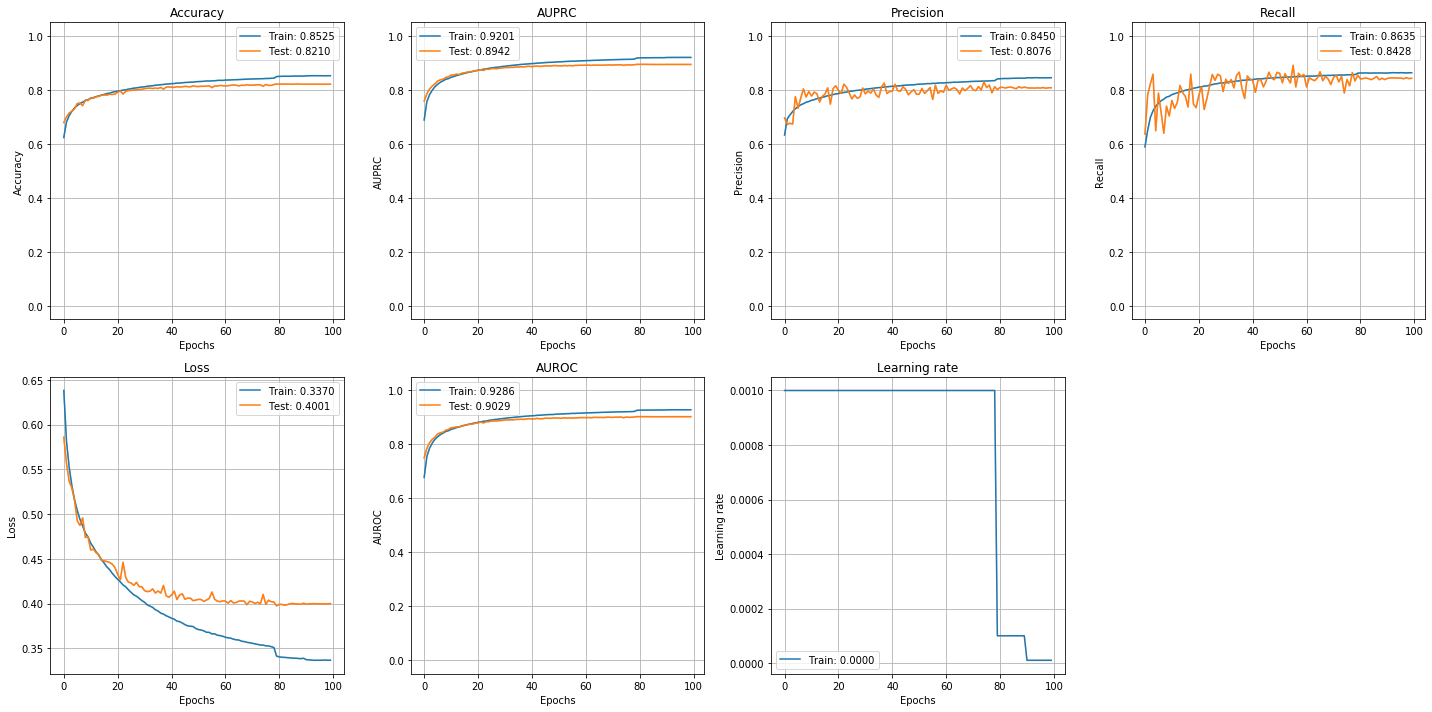

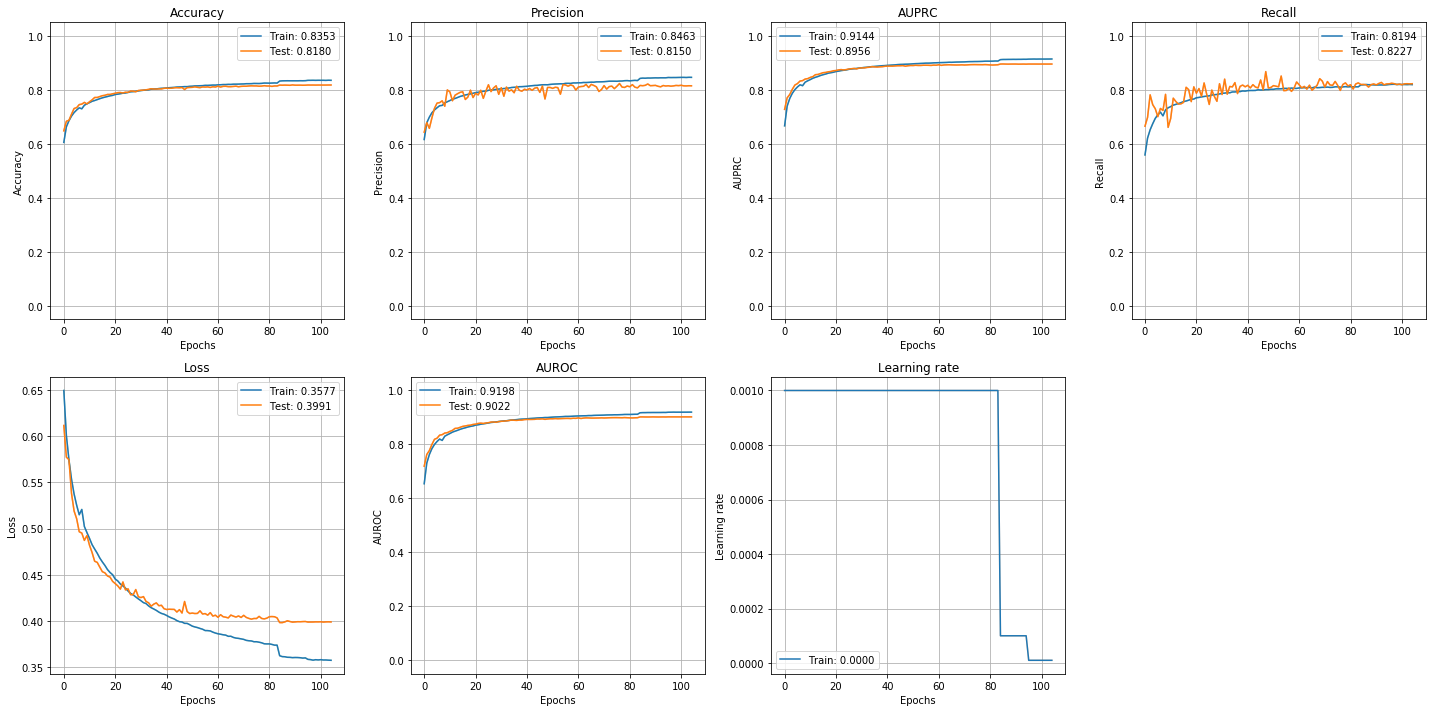

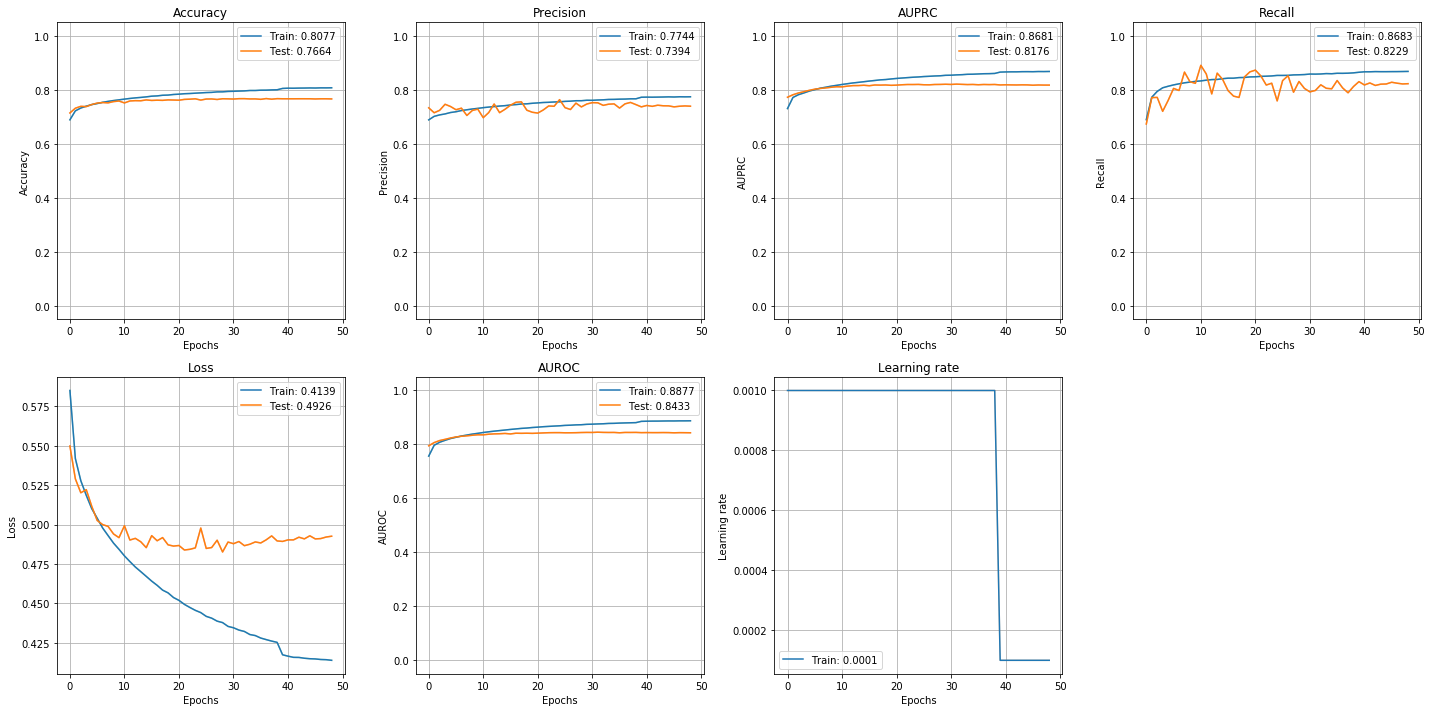

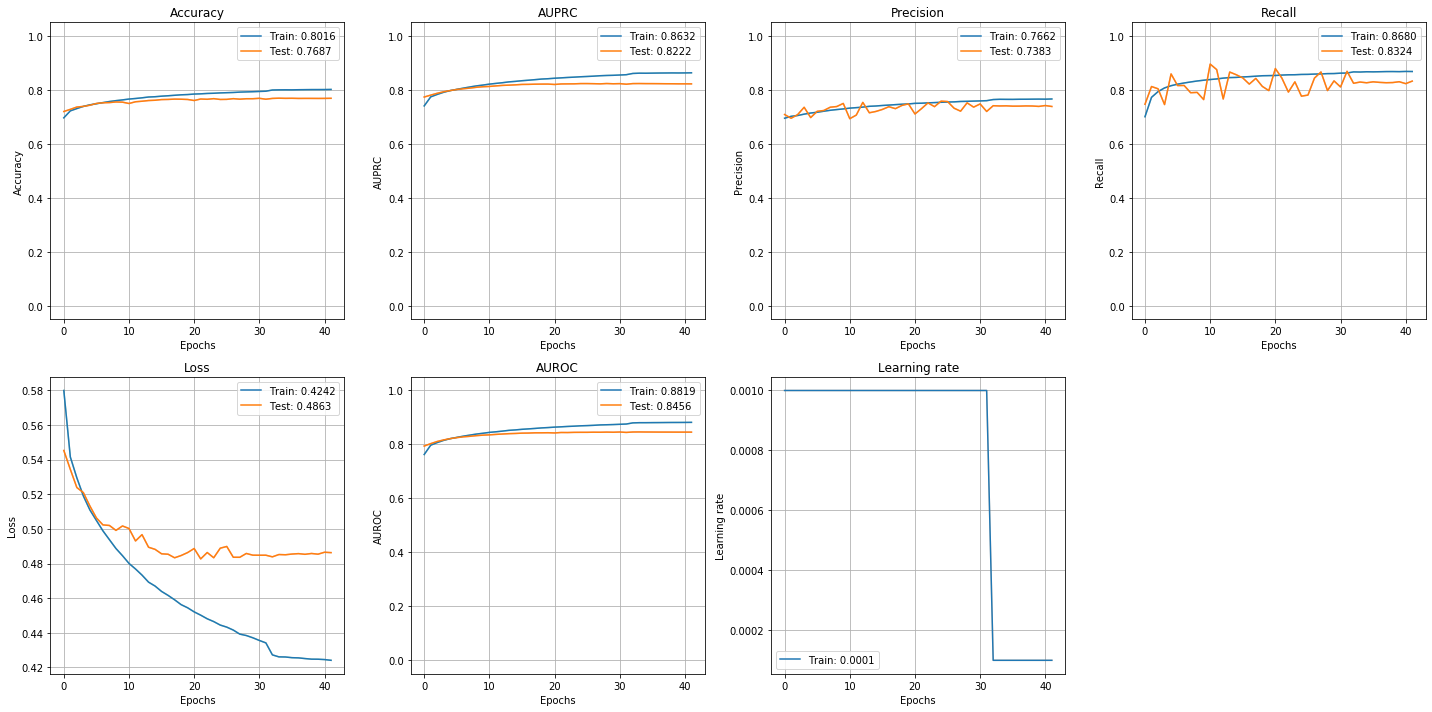

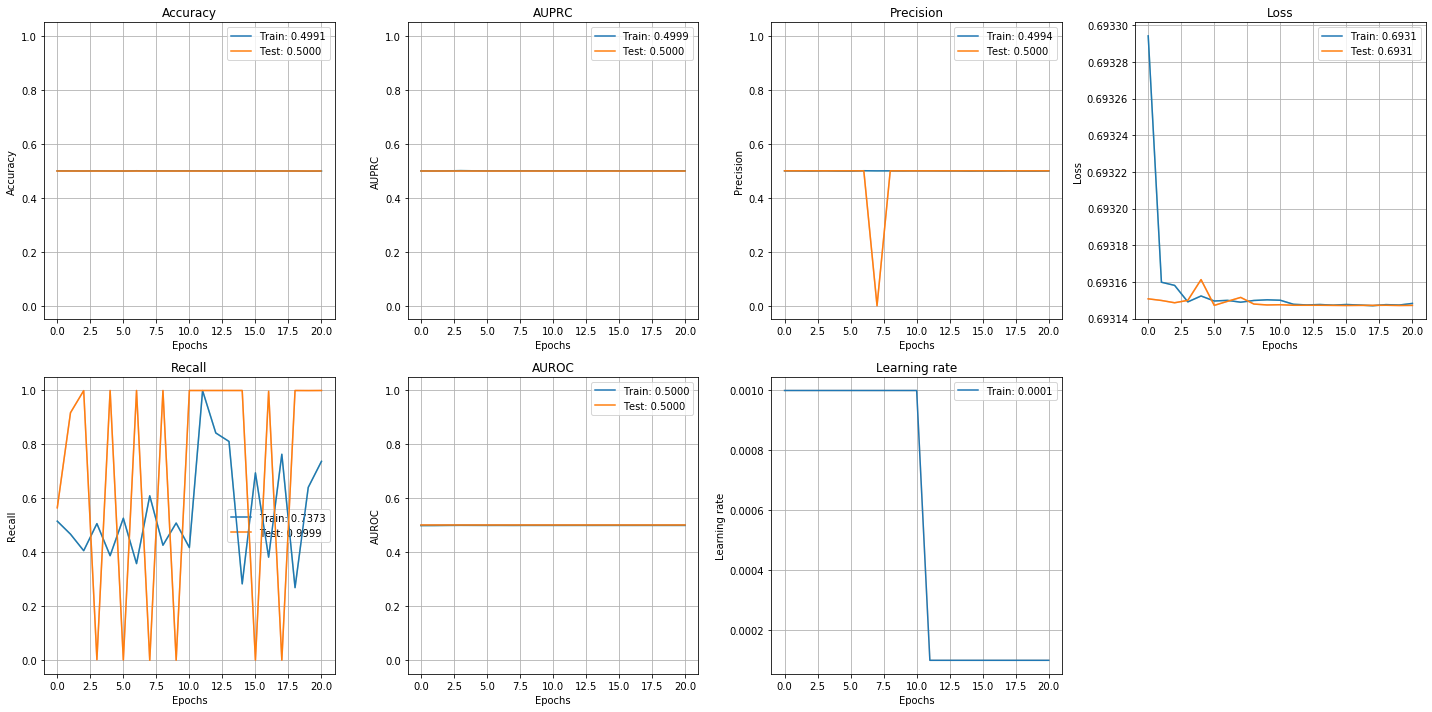

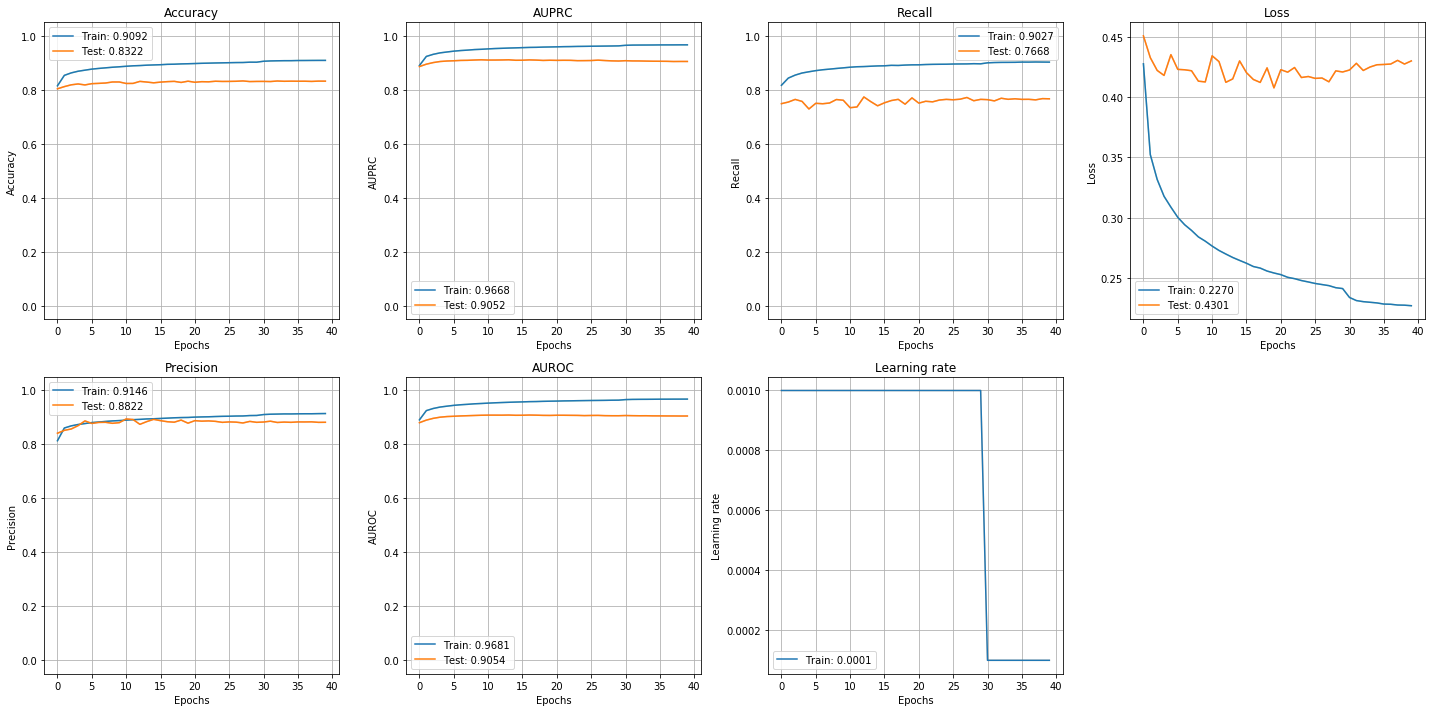

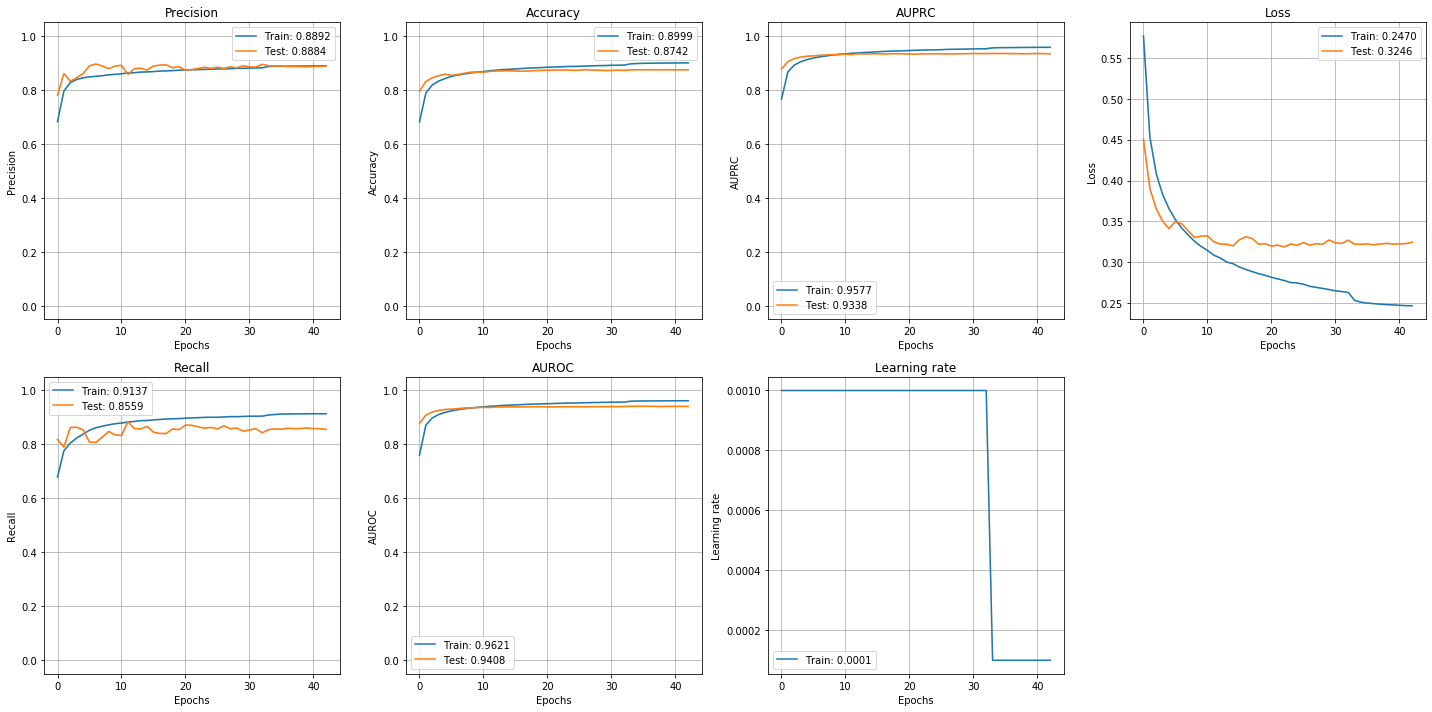

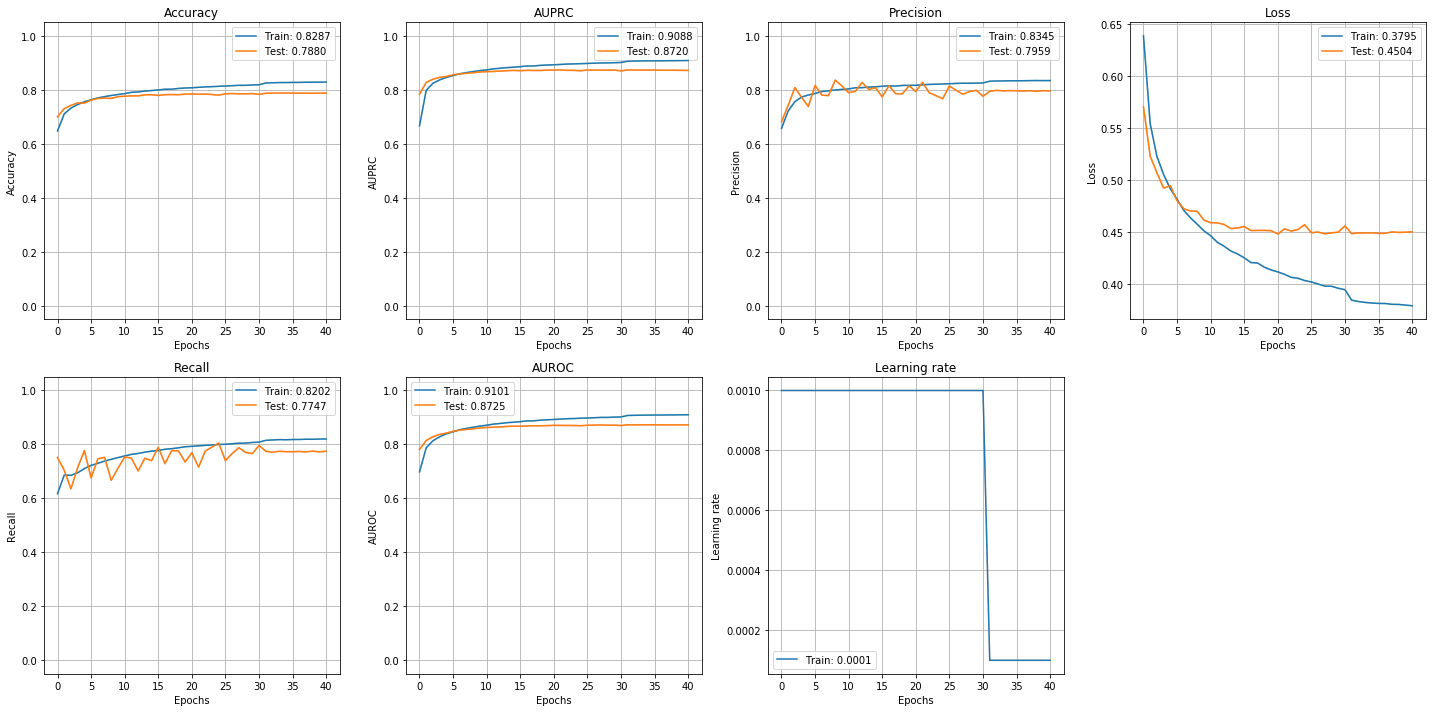

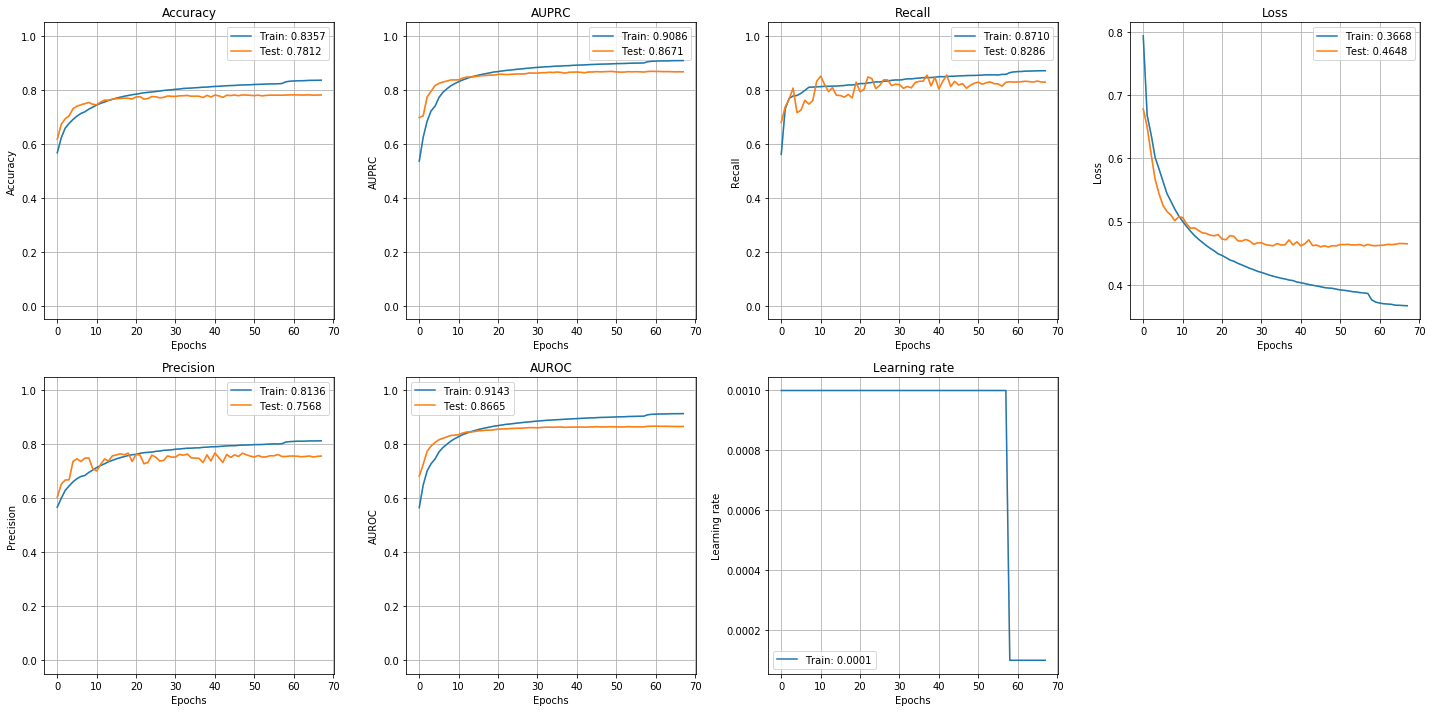

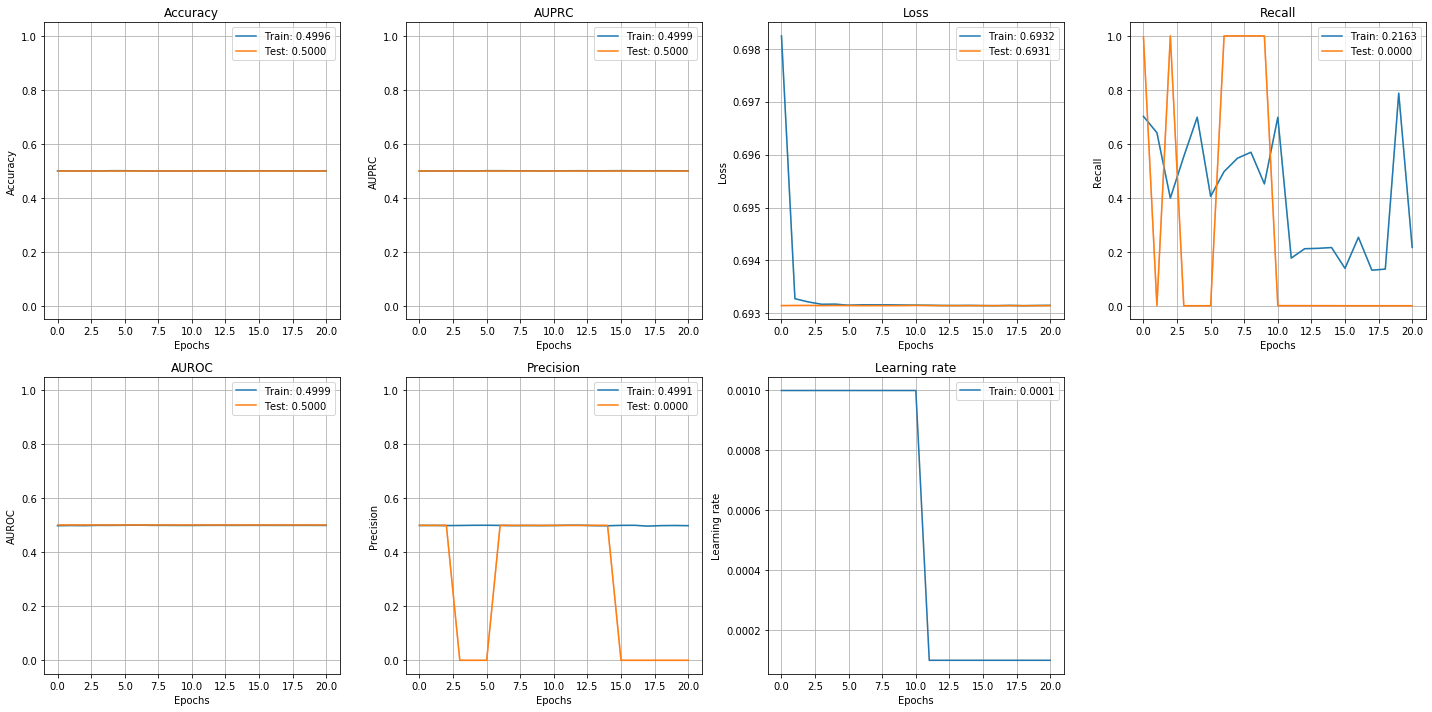

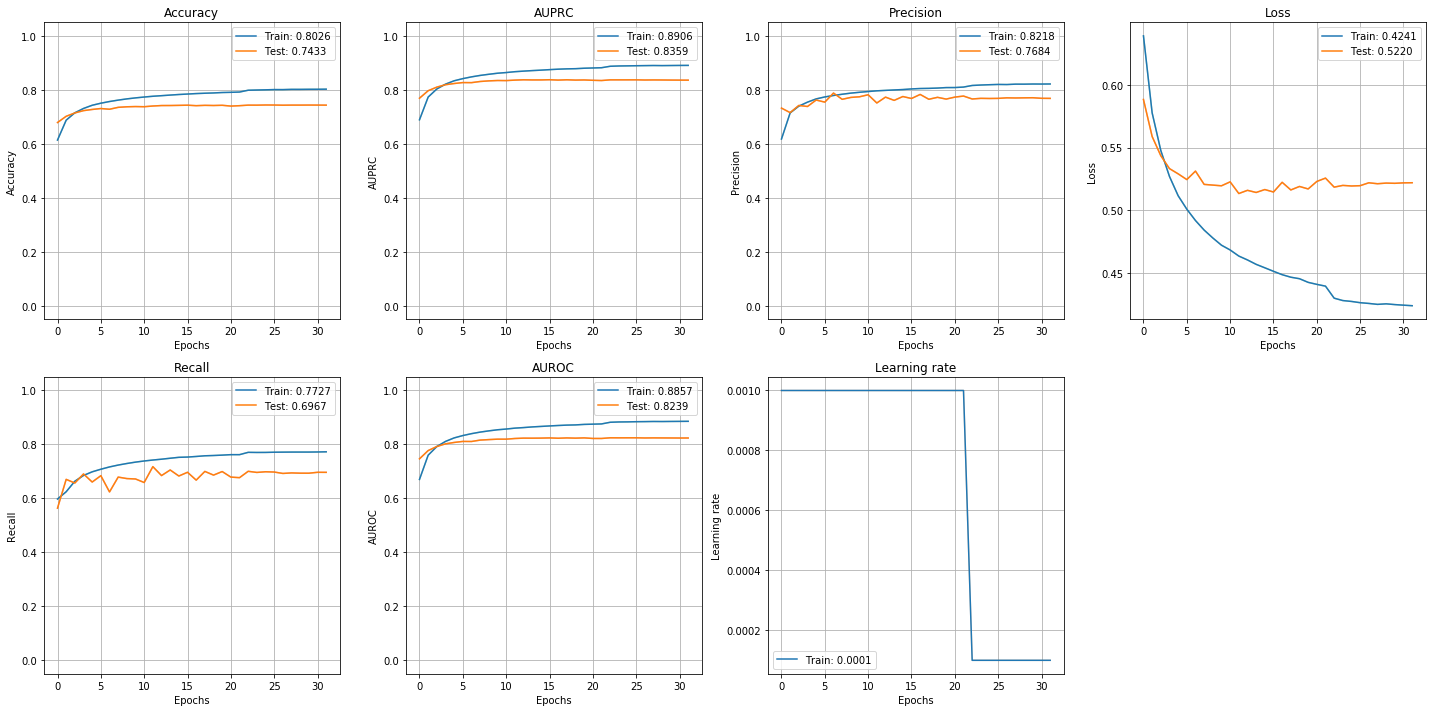

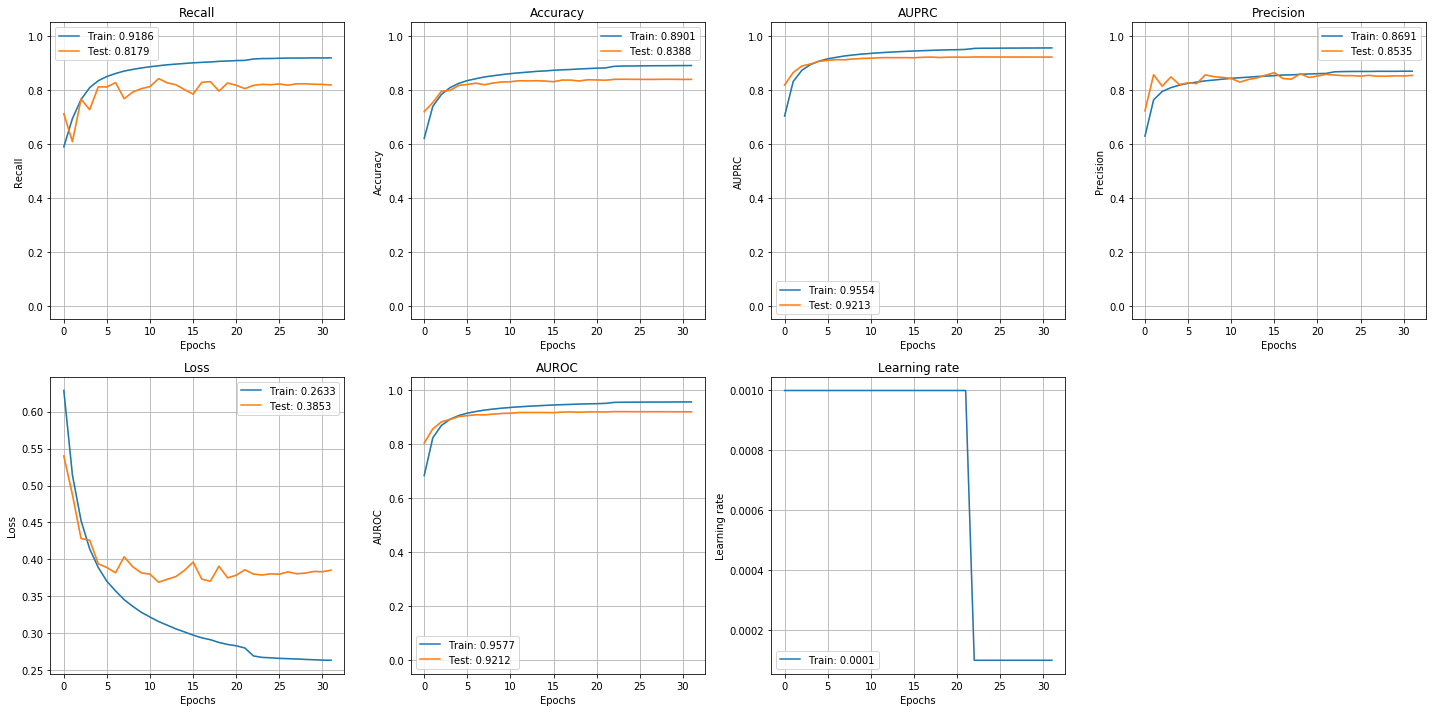

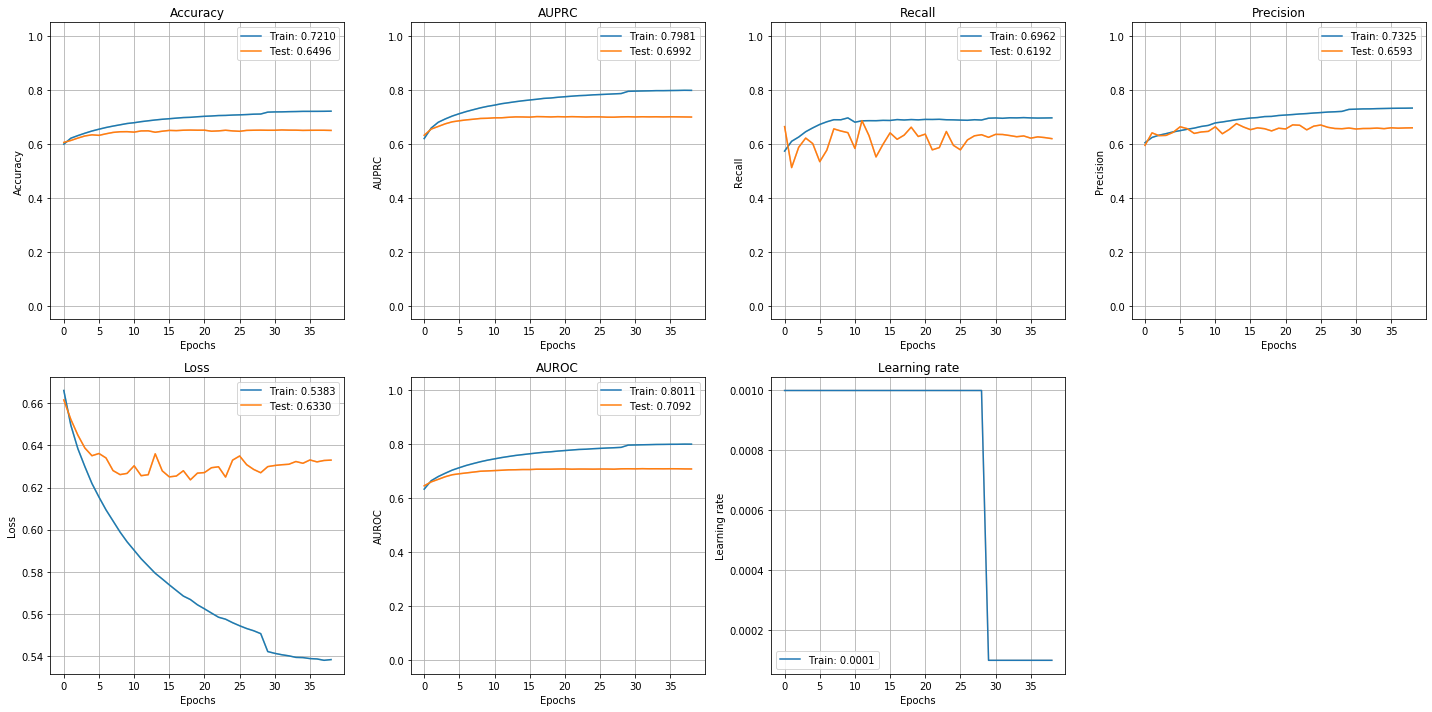

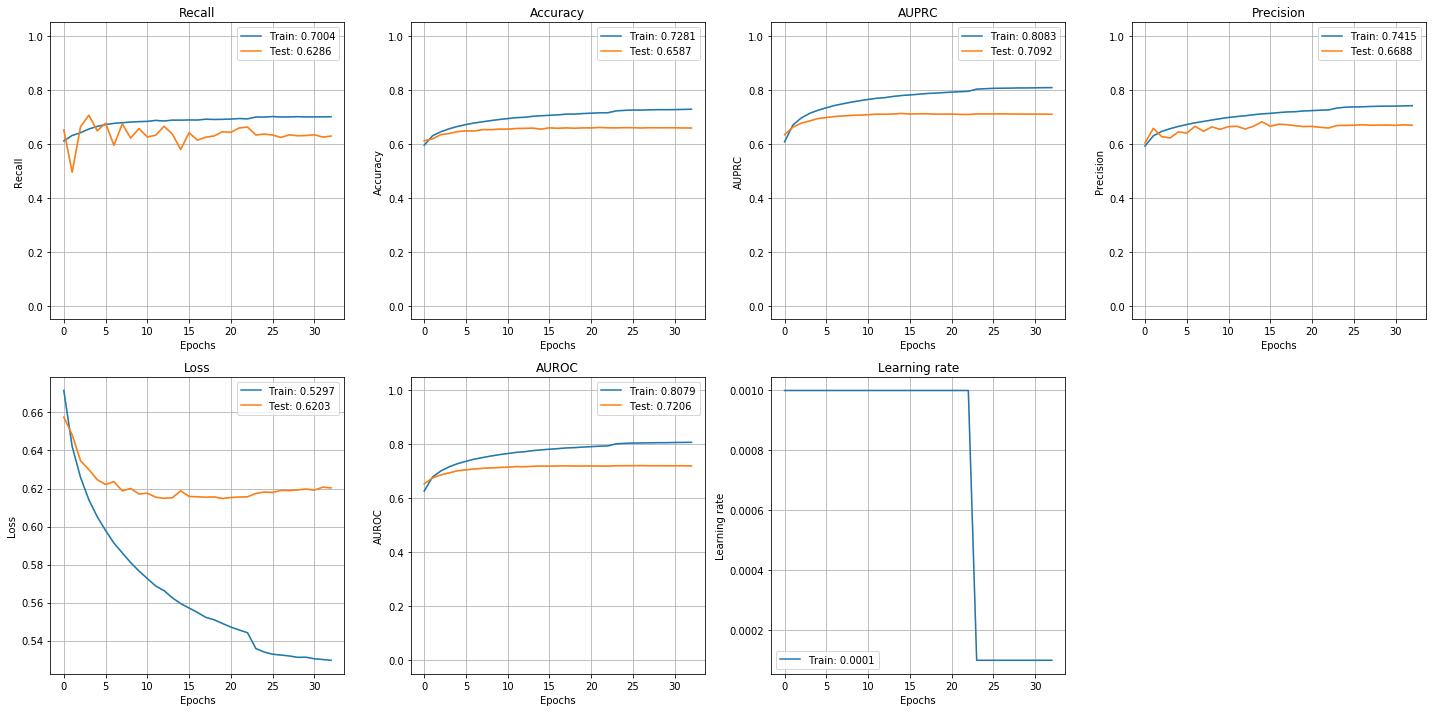

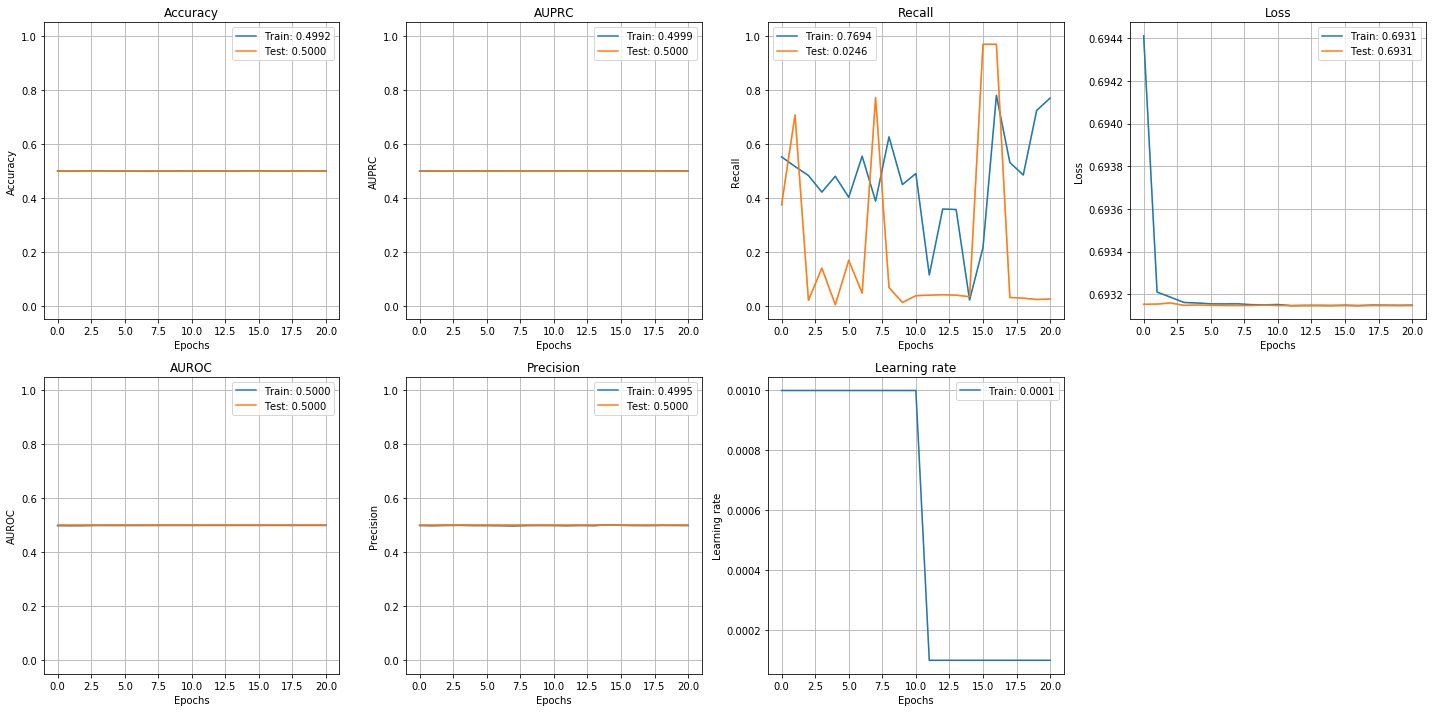

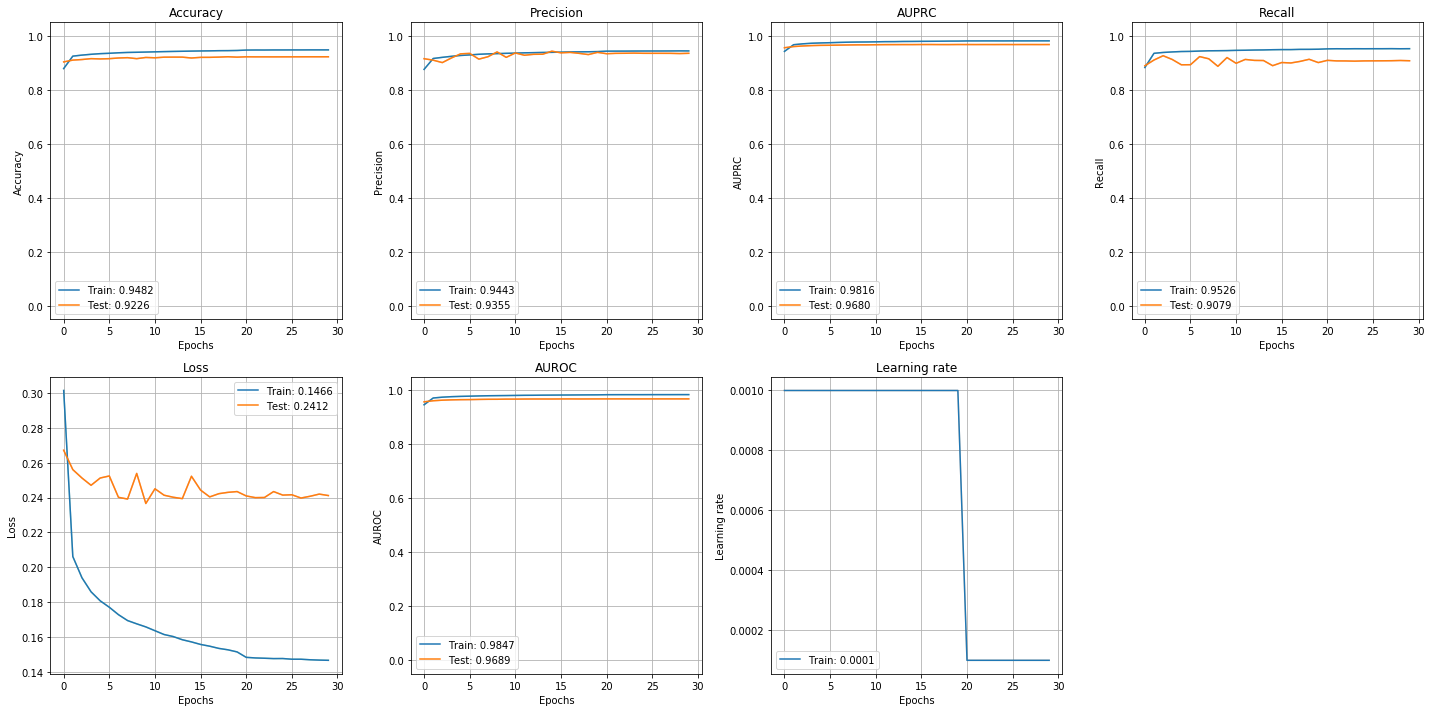

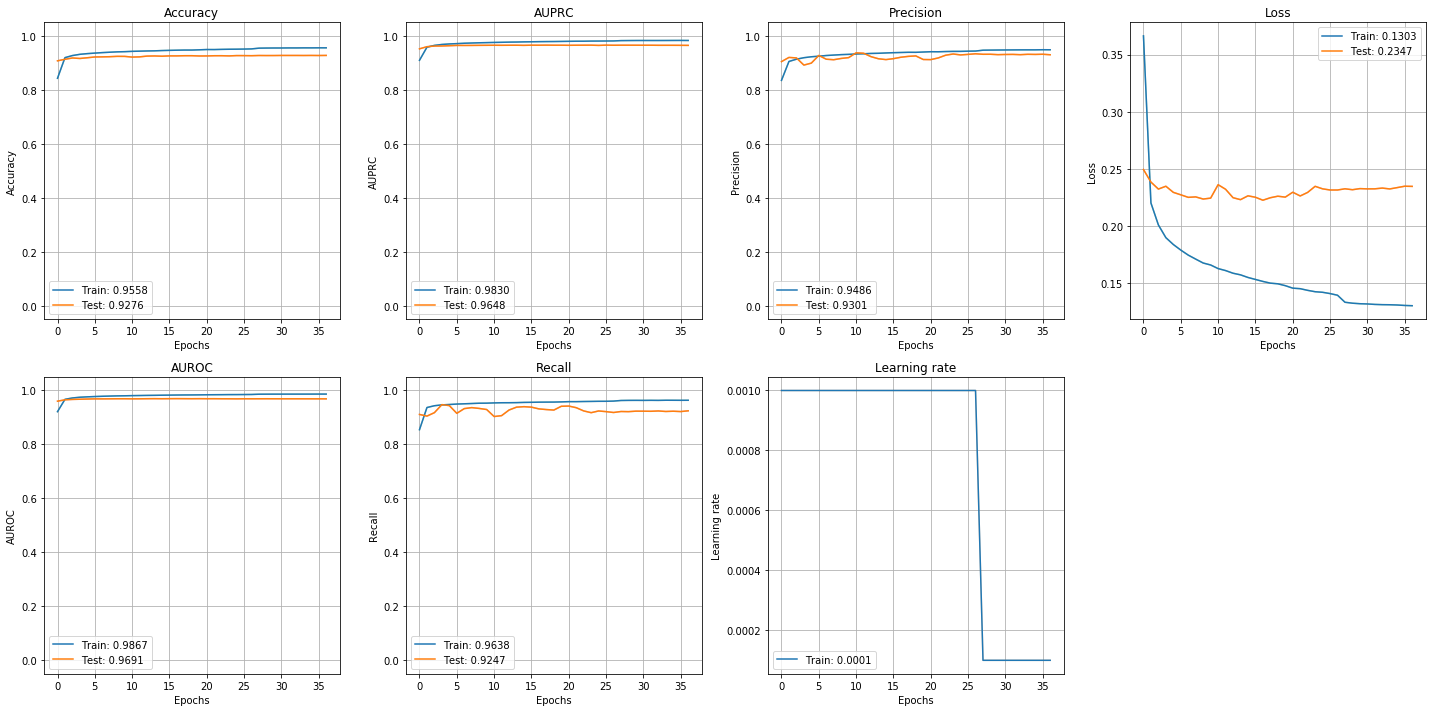

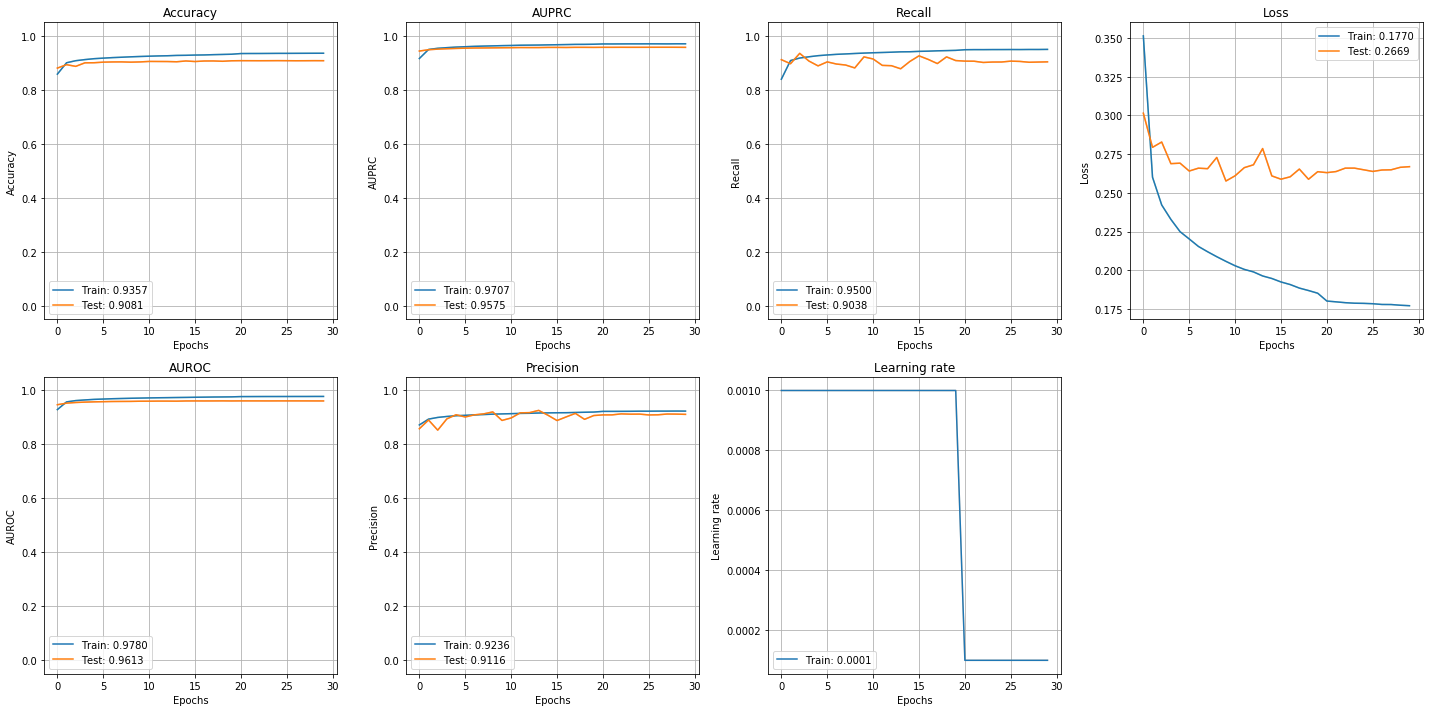

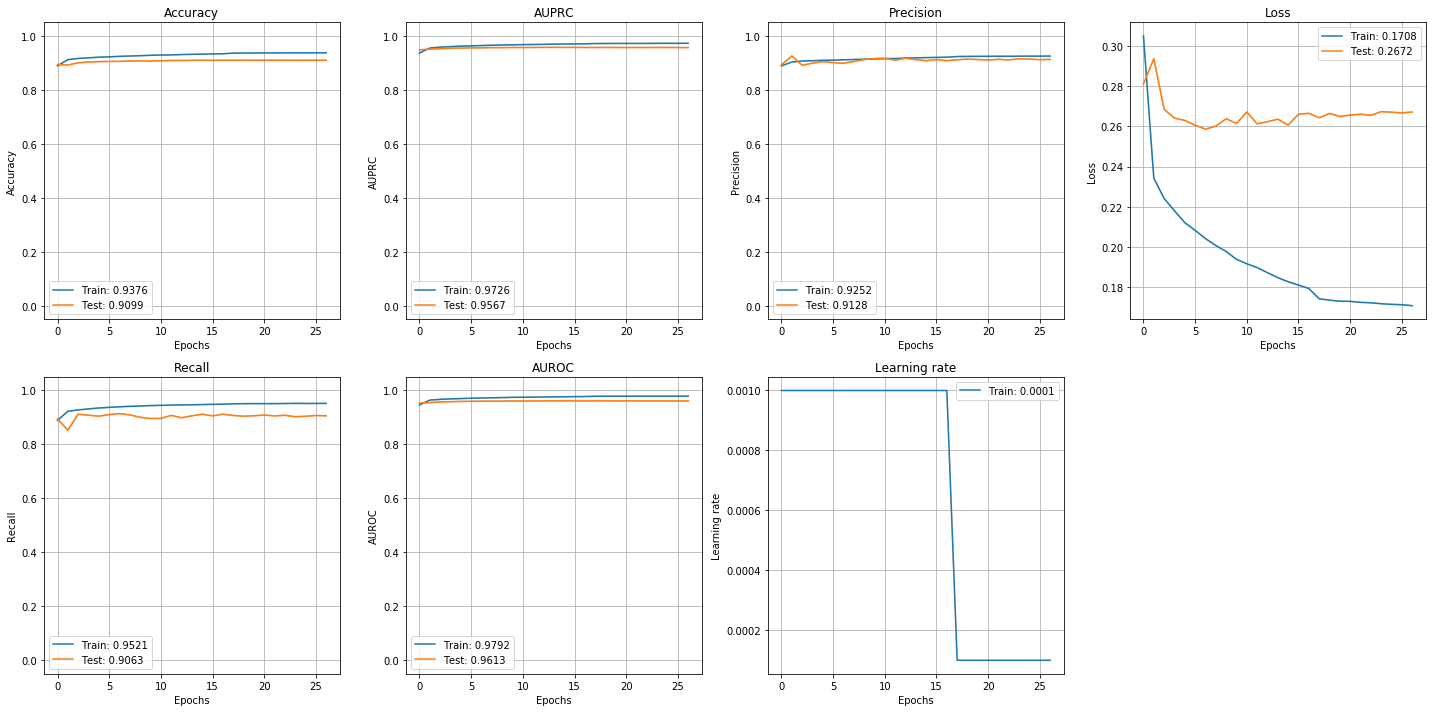

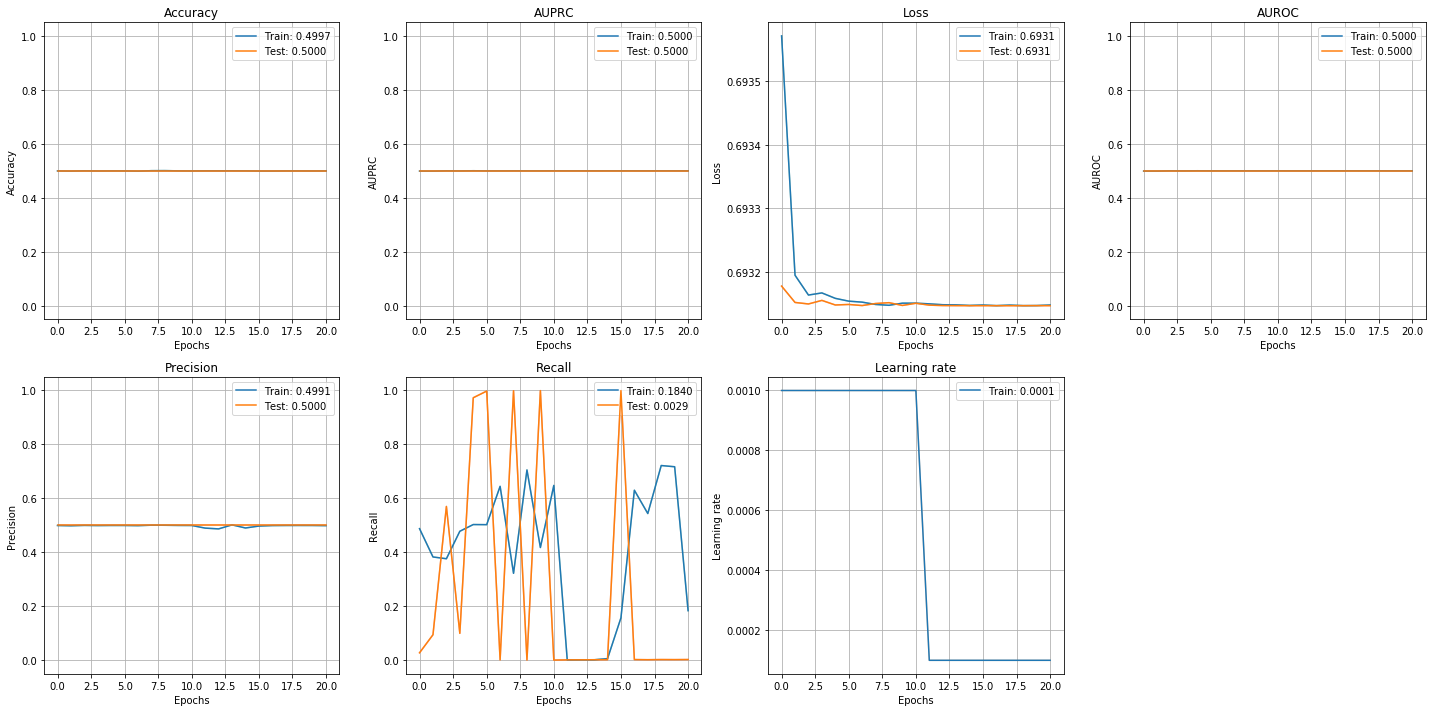

In [8]:
from plot_keras_history import plot_history

for history in histories.values():
    plot_history(history)

## Displaying results of various embedding methods

First we covert the histories into an homogeneous report:

In [9]:
from sanitize_ml_labels import sanitize_ml_labels

report = []
for (model, method), history in histories.items():
    last_epoch = history.iloc[-1].to_dict()
    sanitize = {
        sanitize_ml_labels(label):value
        for label, value in last_epoch.items()
        if label not in ("lr")
    }
    training = {
        key:val
        for key, val in sanitize.items()
        if "Val" not in key
    }
    validation = {
        sanitize_ml_labels(key.replace("Val ", "")):val
        for key, val in sanitize.items()
        if "Val" in key
    }
    
    report.append({
        "run":"training",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **training
    })
    report.append({
        "run":"validation",
        "embedding_model":model,
        "model":"MLP",
        "method":method,
        **validation
    })

report = pd.DataFrame(report)

## Training link prediction on some other models
Here we execute the link prediction using Random Forests, Decision Trees and Logistic Regression so to have a good comparison.

In [10]:
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import cpu_count

kwargs = {
    "DecisionTreeClassifier":dict(
        max_depth=30,
        random_state=42
    ),
    "RandomForestClassifier":dict(
        n_estimators=500,
        max_depth=30,
        n_jobs=cpu_count(),
        random_state=42
    ),
    "LogisticRegression":dict(
        random_state=42,
        max_iter=1000
    )
}

def metric_report(y_true, y_pred):
    metrics = (
        roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score
    )
    return {
        sanitize_ml_labels(metric.__name__):metric(y_true, y_pred)
        for metric in metrics
    }

metrics_reports_path = "classical_link_prediction/linear_models_reports.csv"
if os.path.exists(metrics_reports_path):
    metrics_reports = pd.read_csv(metrics_reports_path)
else:
    metrics_reports = []

    for embedding_model, method, train, valid in task_generator(pos_training, pos_validation, neg_training, neg_validation):
        for model_builder in tqdm((DecisionTreeClassifier, RandomForestClassifier, LogisticRegression), desc="Model", leave=False):
            model = model_builder(**kwargs[model_builder.__name__])
            train_x, train_y = train
            valid_x, valid_y = valid
            model.fit(train_x, train_y)
            train_y_pred = model.predict(train_x)
            valid_y_pred = model.predict(valid_x)
            metrics_reports.append({
                "run":"training",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(train_y, train_y_pred)
            })
            metrics_reports.append({
                "run":"validation",
                "embedding_model":embedding_model,
                "model":model_builder.__name__,
                "method":method,
                **metric_report(valid_y, valid_y_pred)
            })

    metrics_reports = pd.DataFrame(metrics_reports)
    metrics_reports.to_csv(metrics_reports_path, index=None)
    

/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-pack

/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-pack

/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-pack

/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/cappelletti_luca94/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Merging reports

In [14]:
all_reports = pd.concat([
    metrics_reports,
    report
])

all_reports.to_csv("classical_link_prediction/all_reports.csv", index=None)

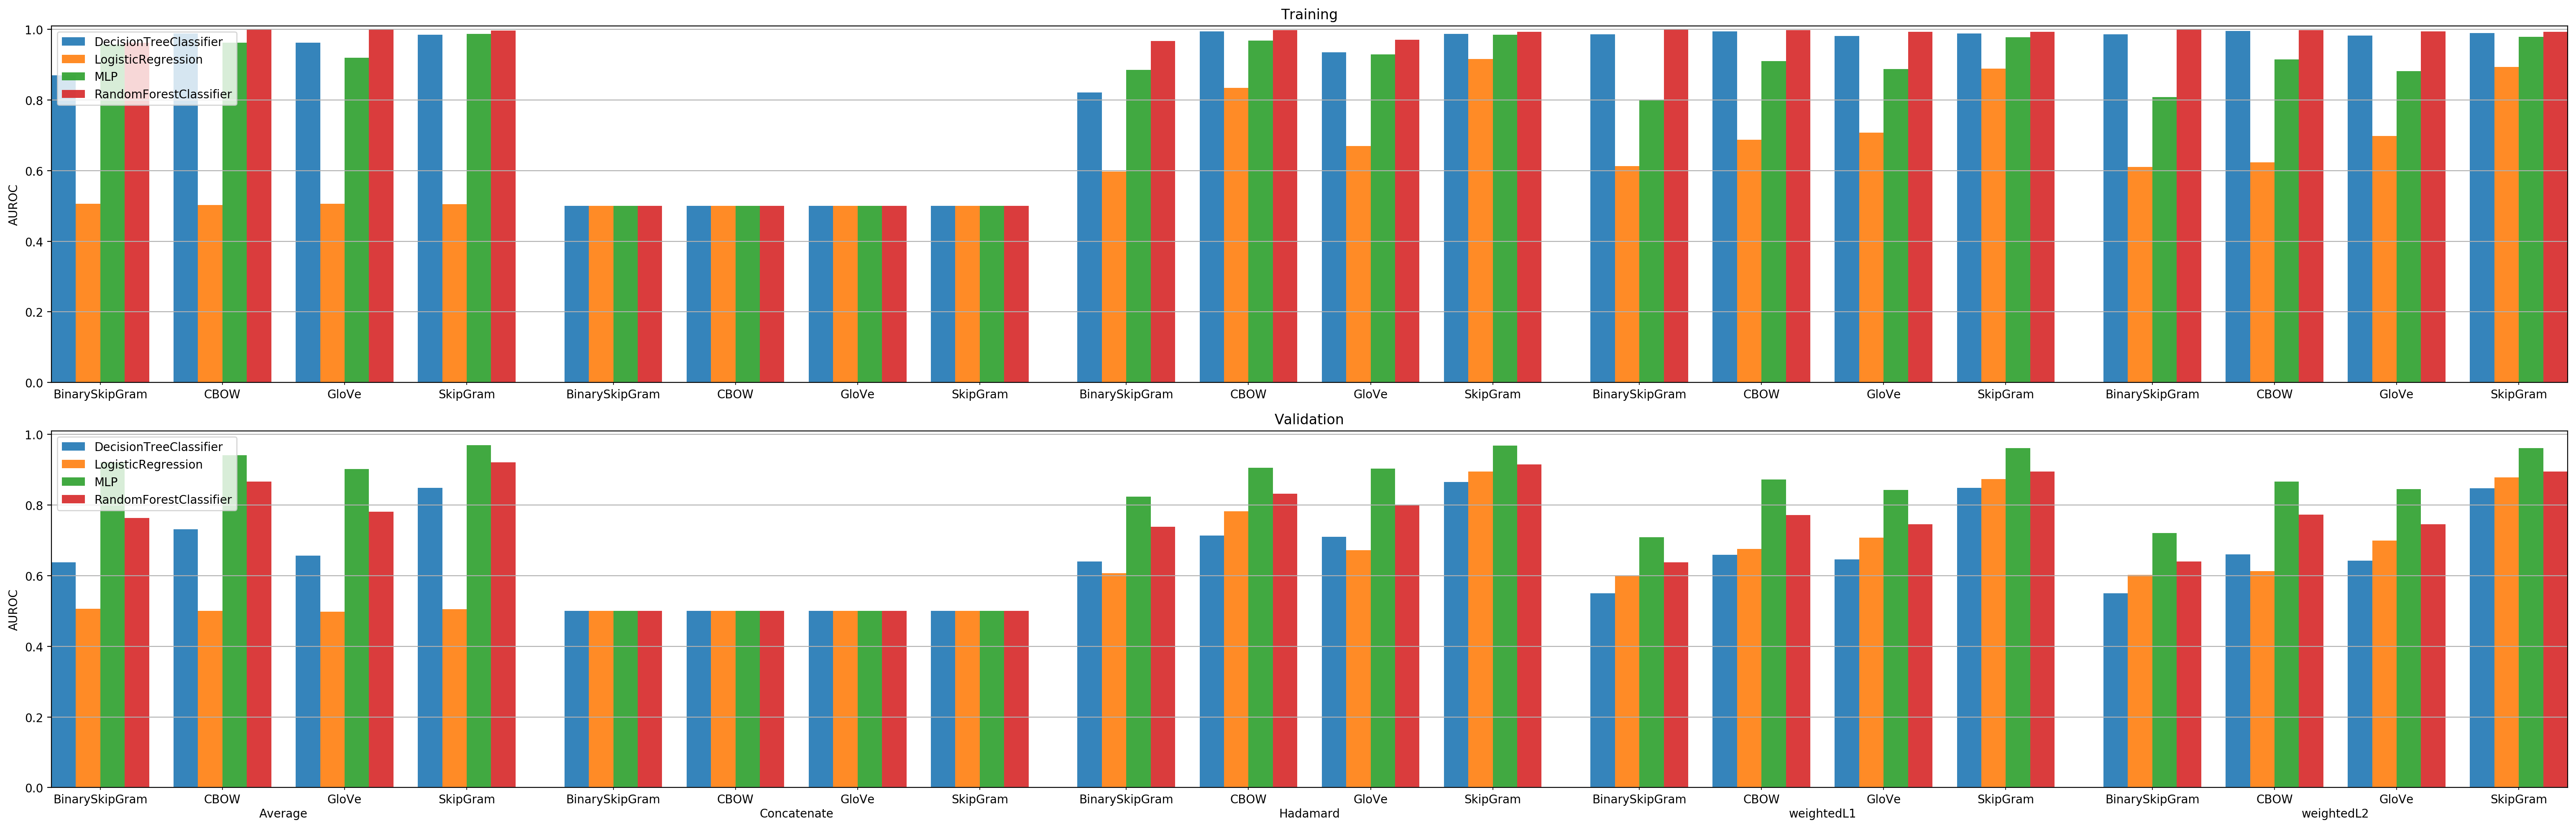

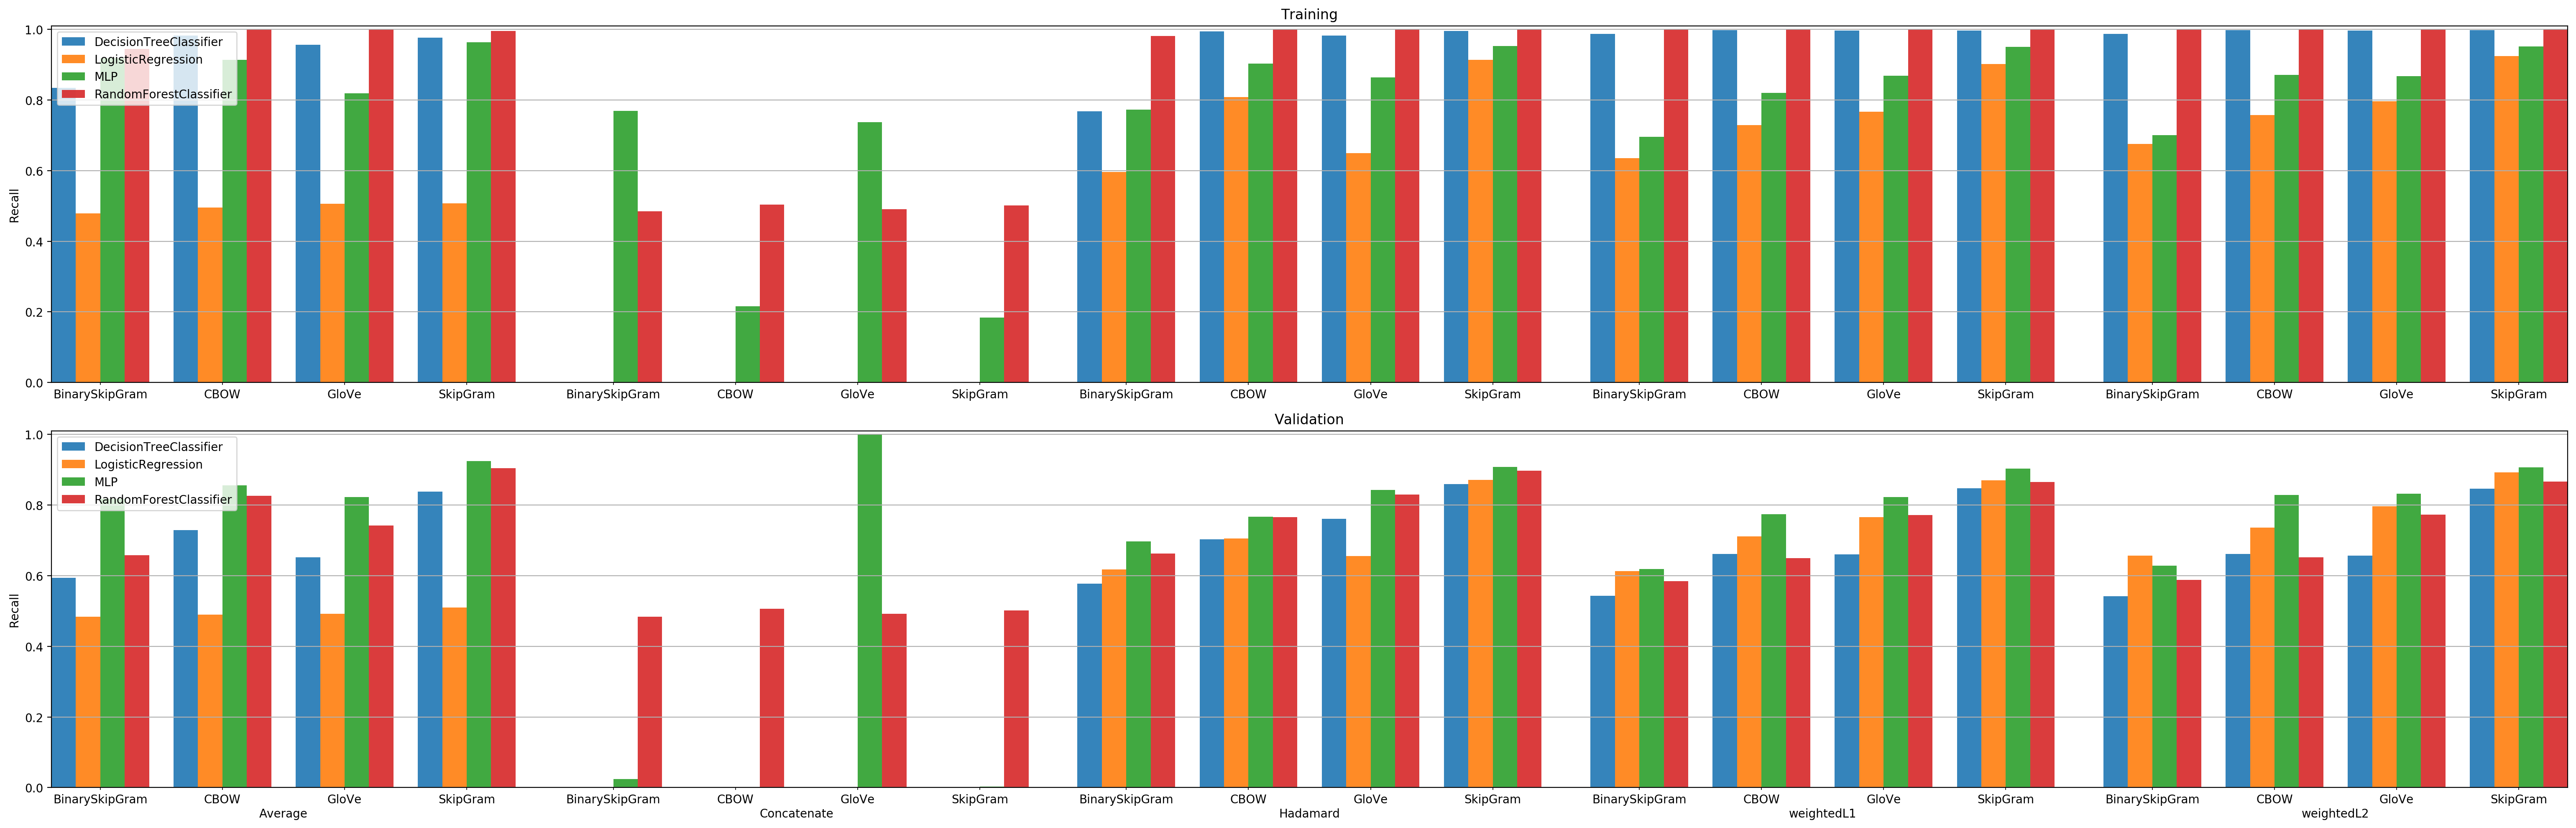

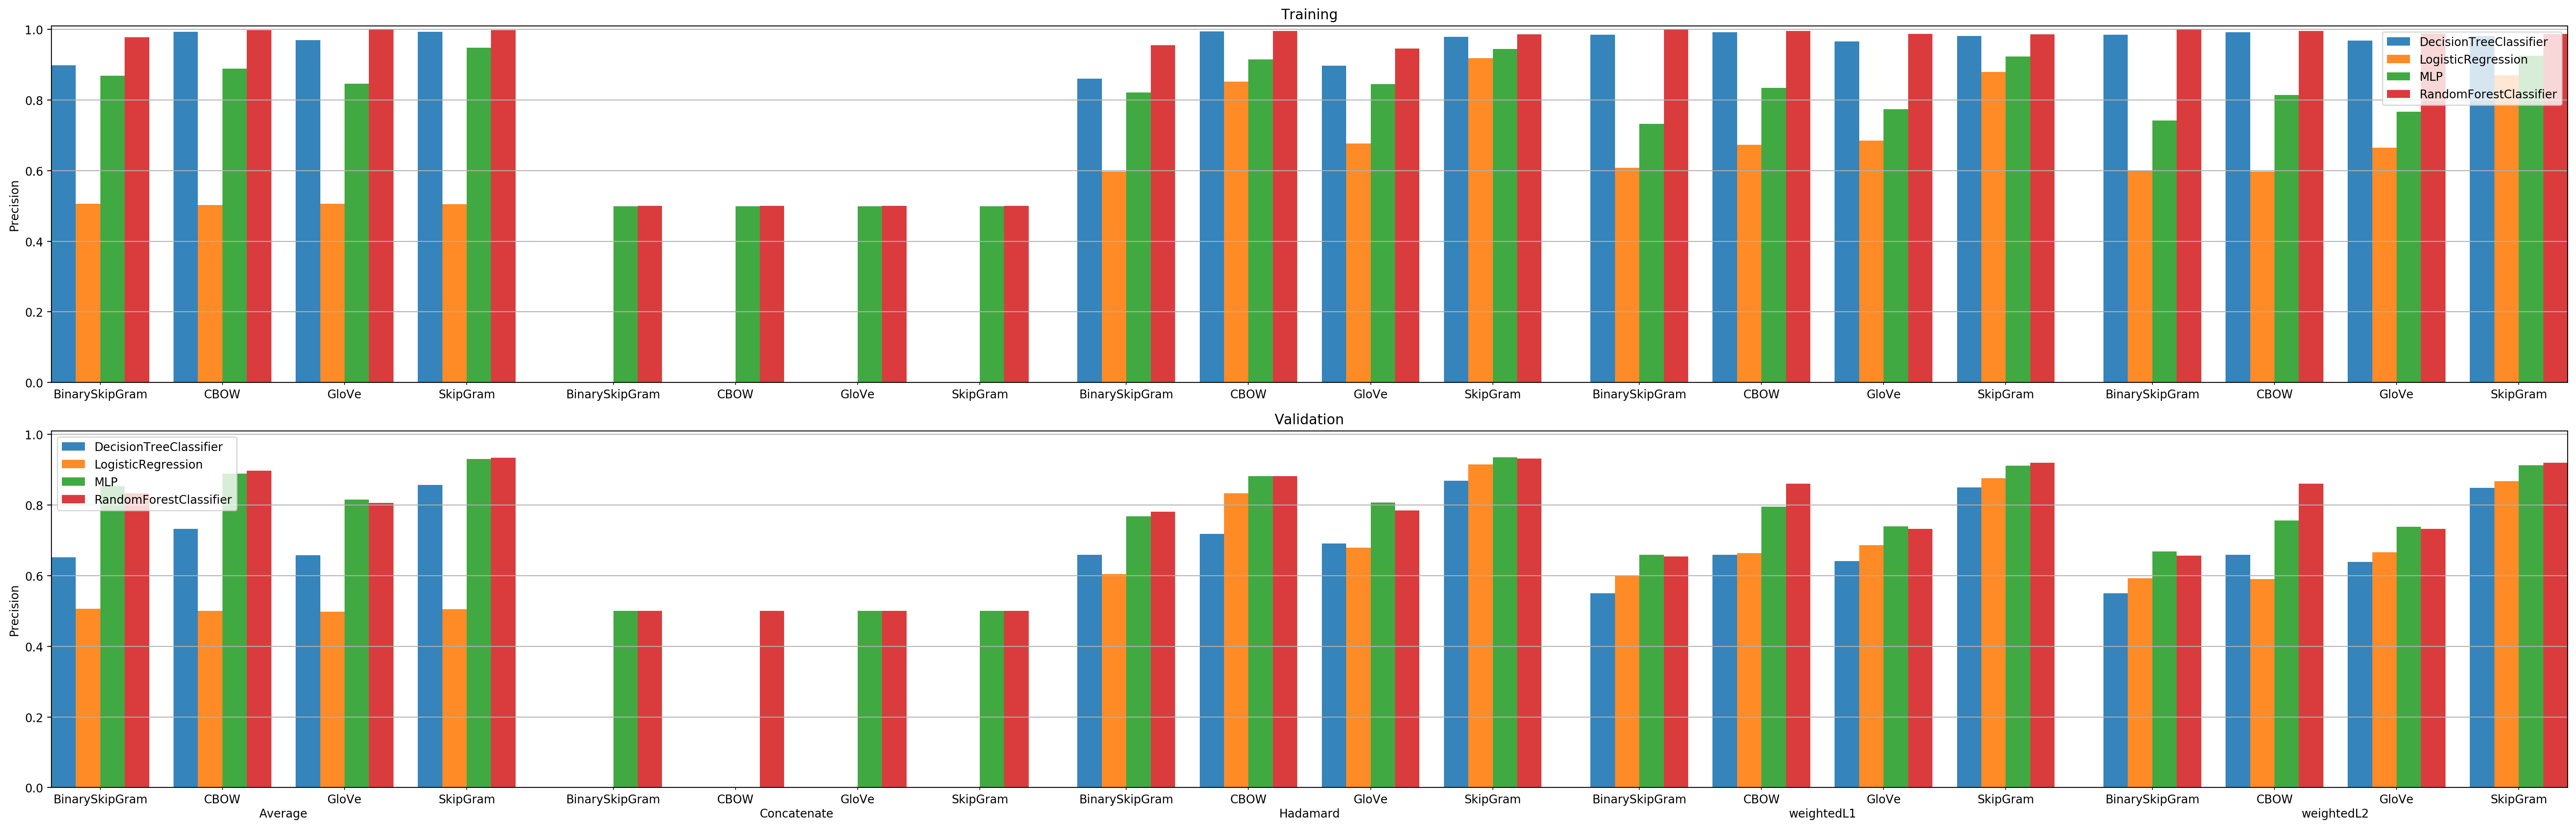

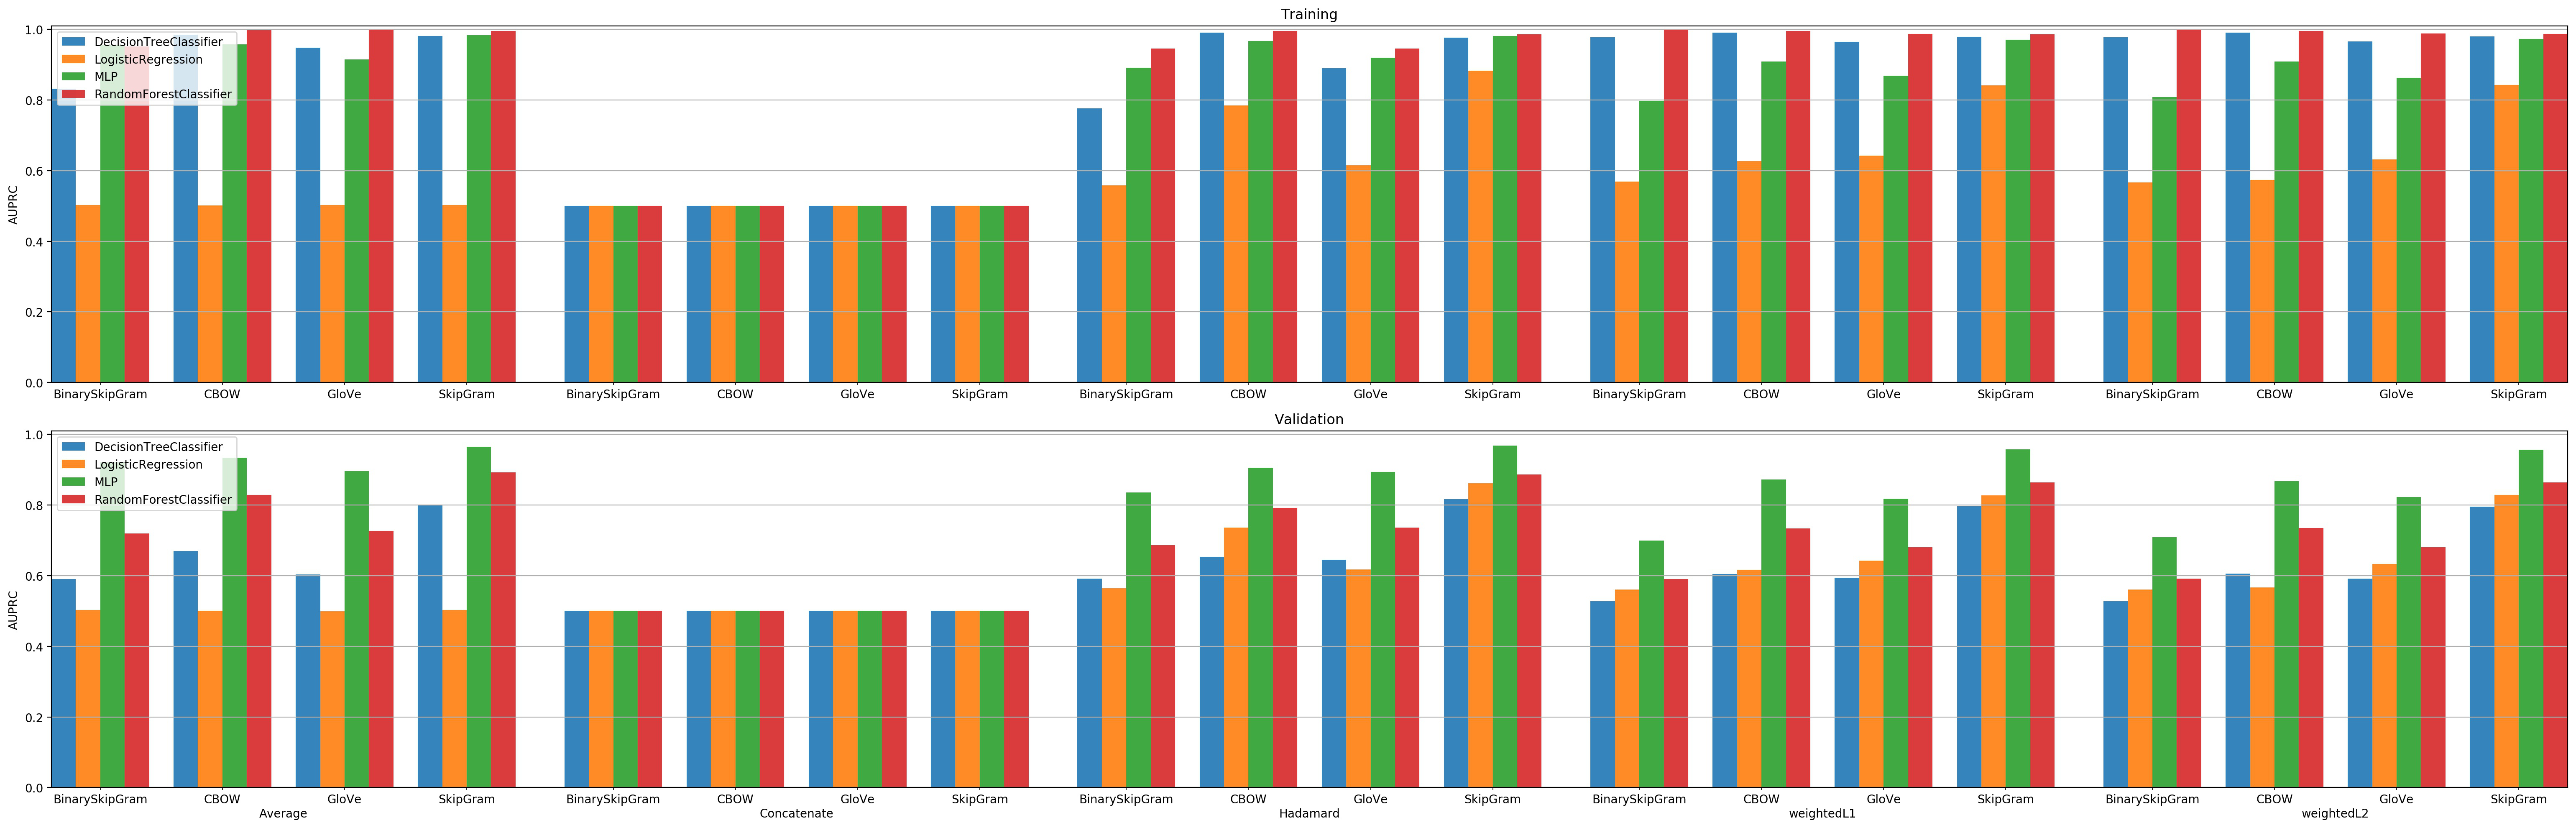

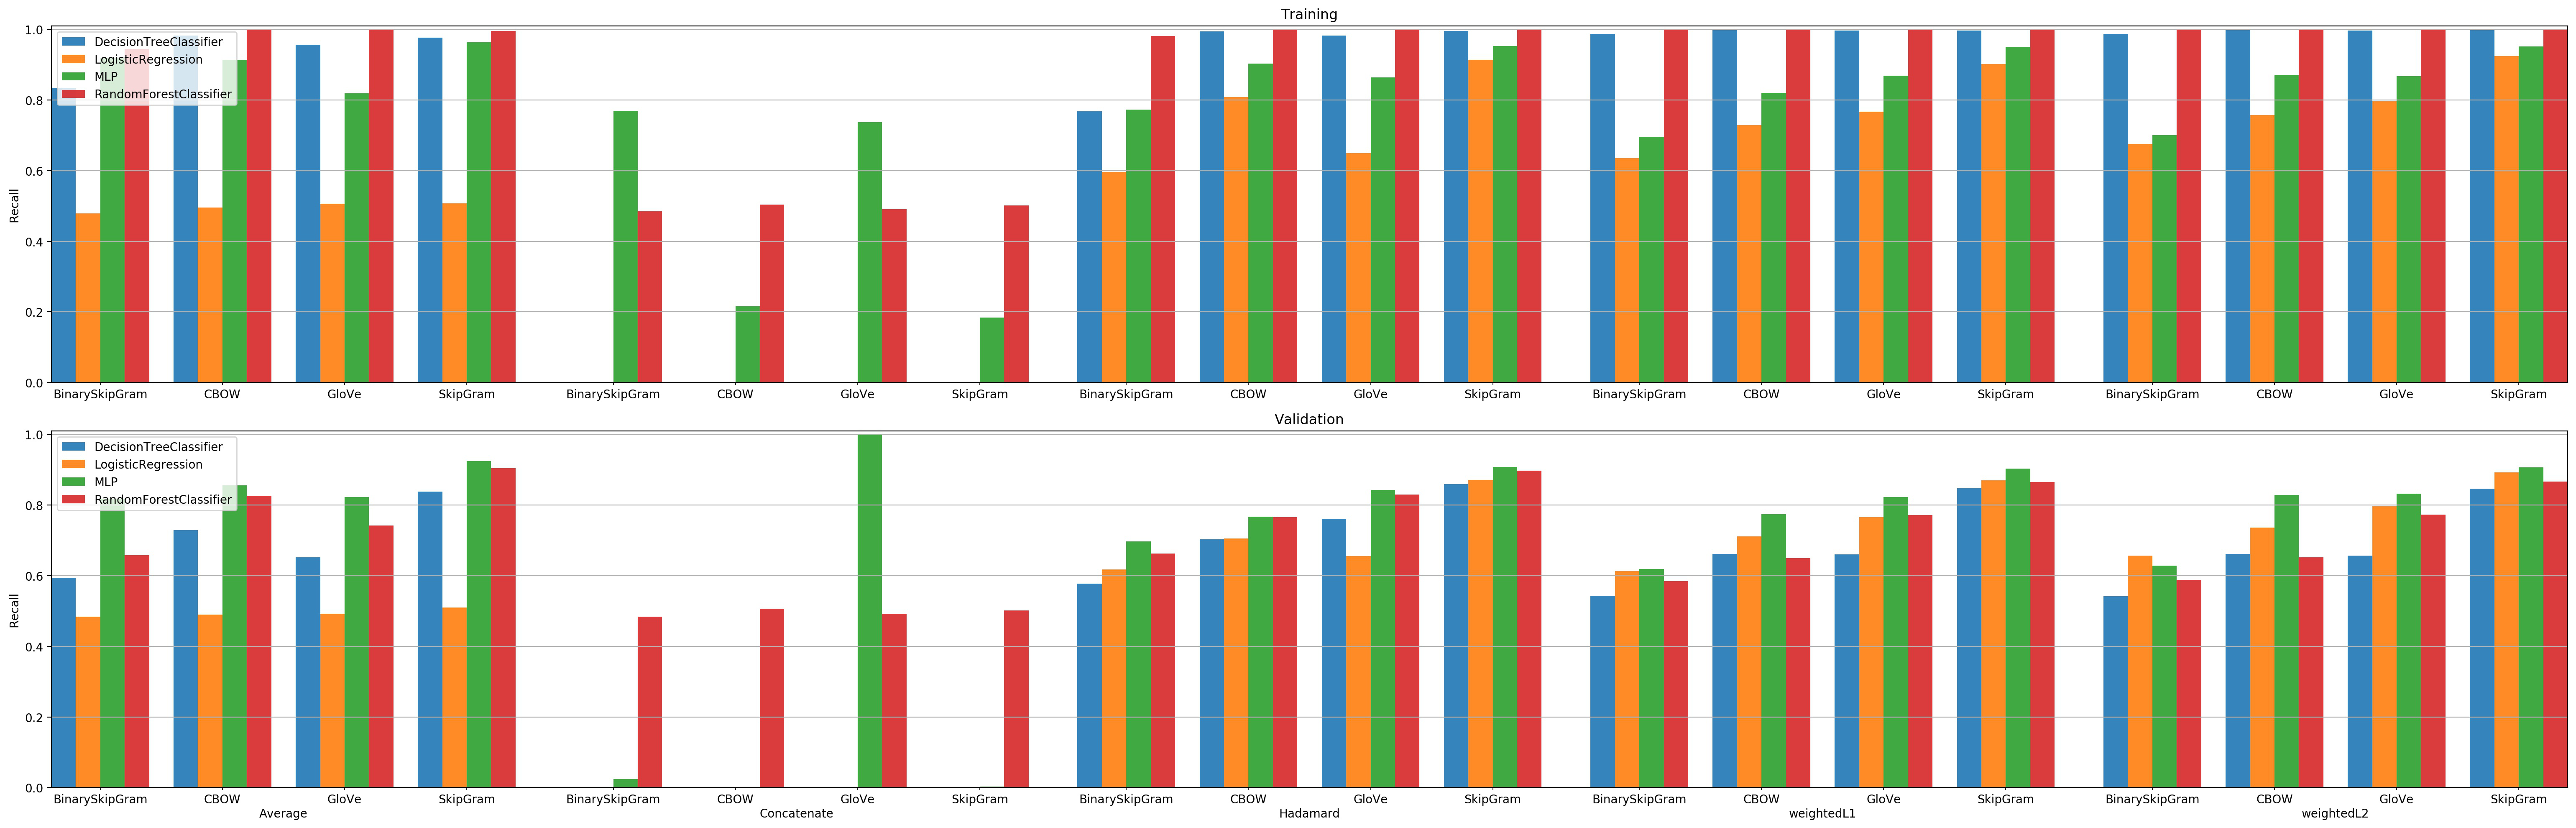

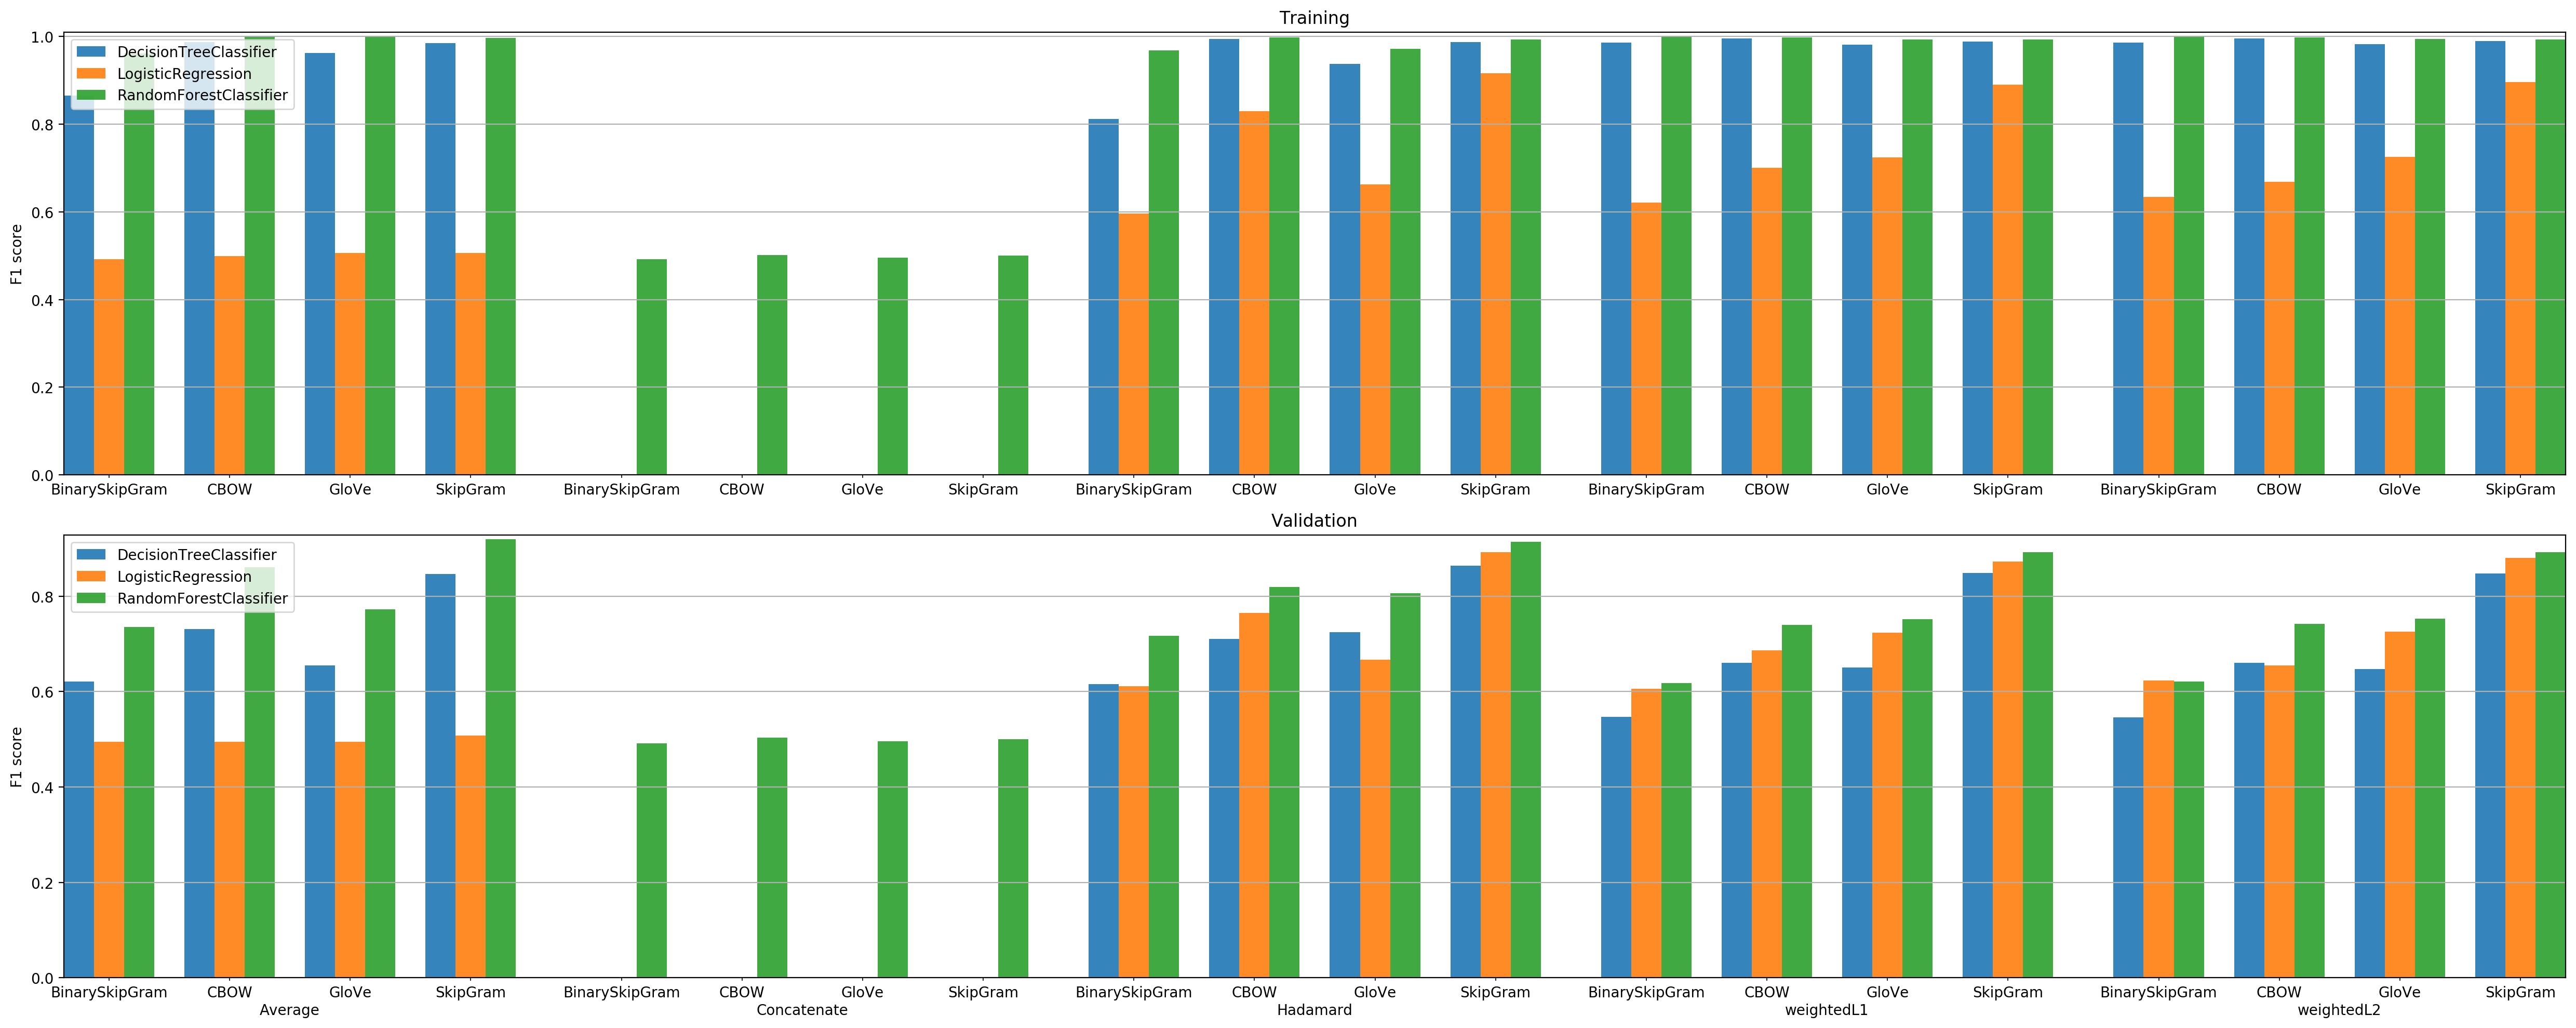

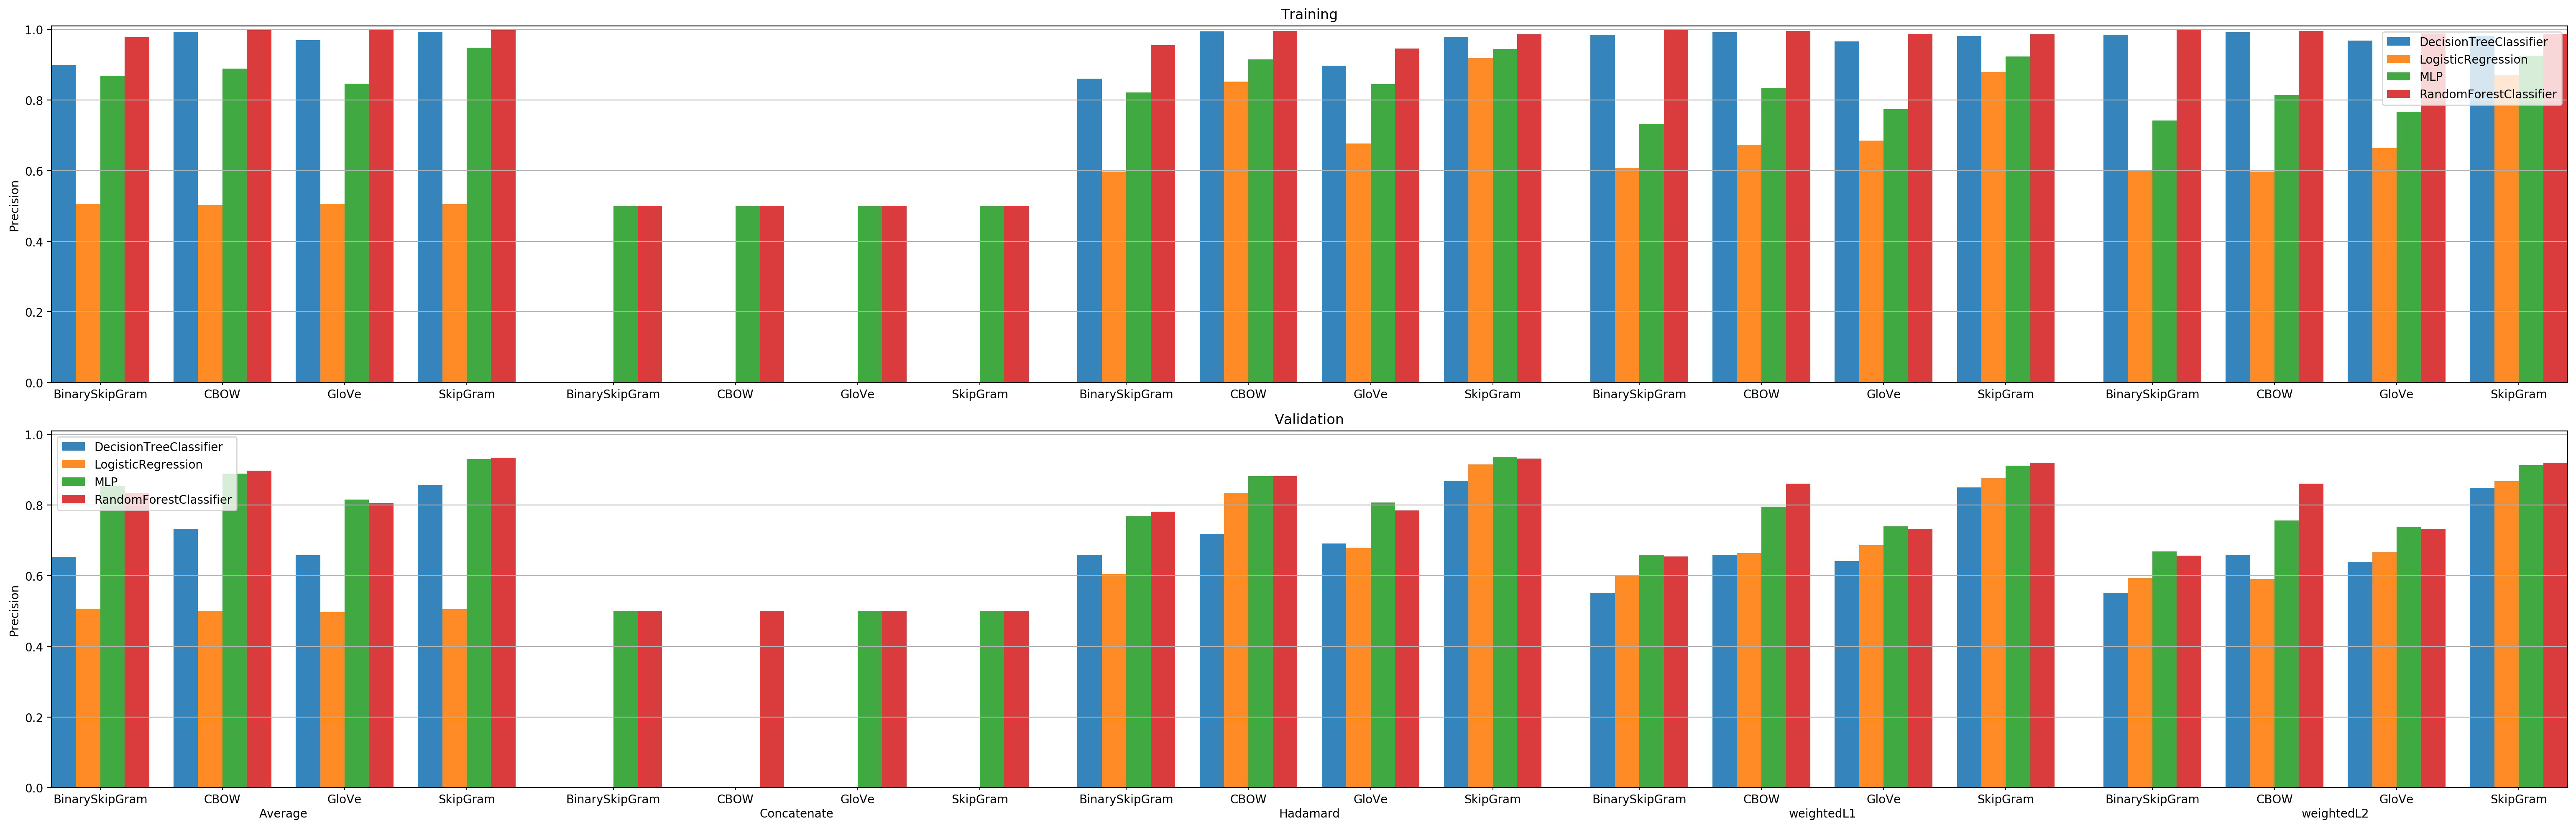

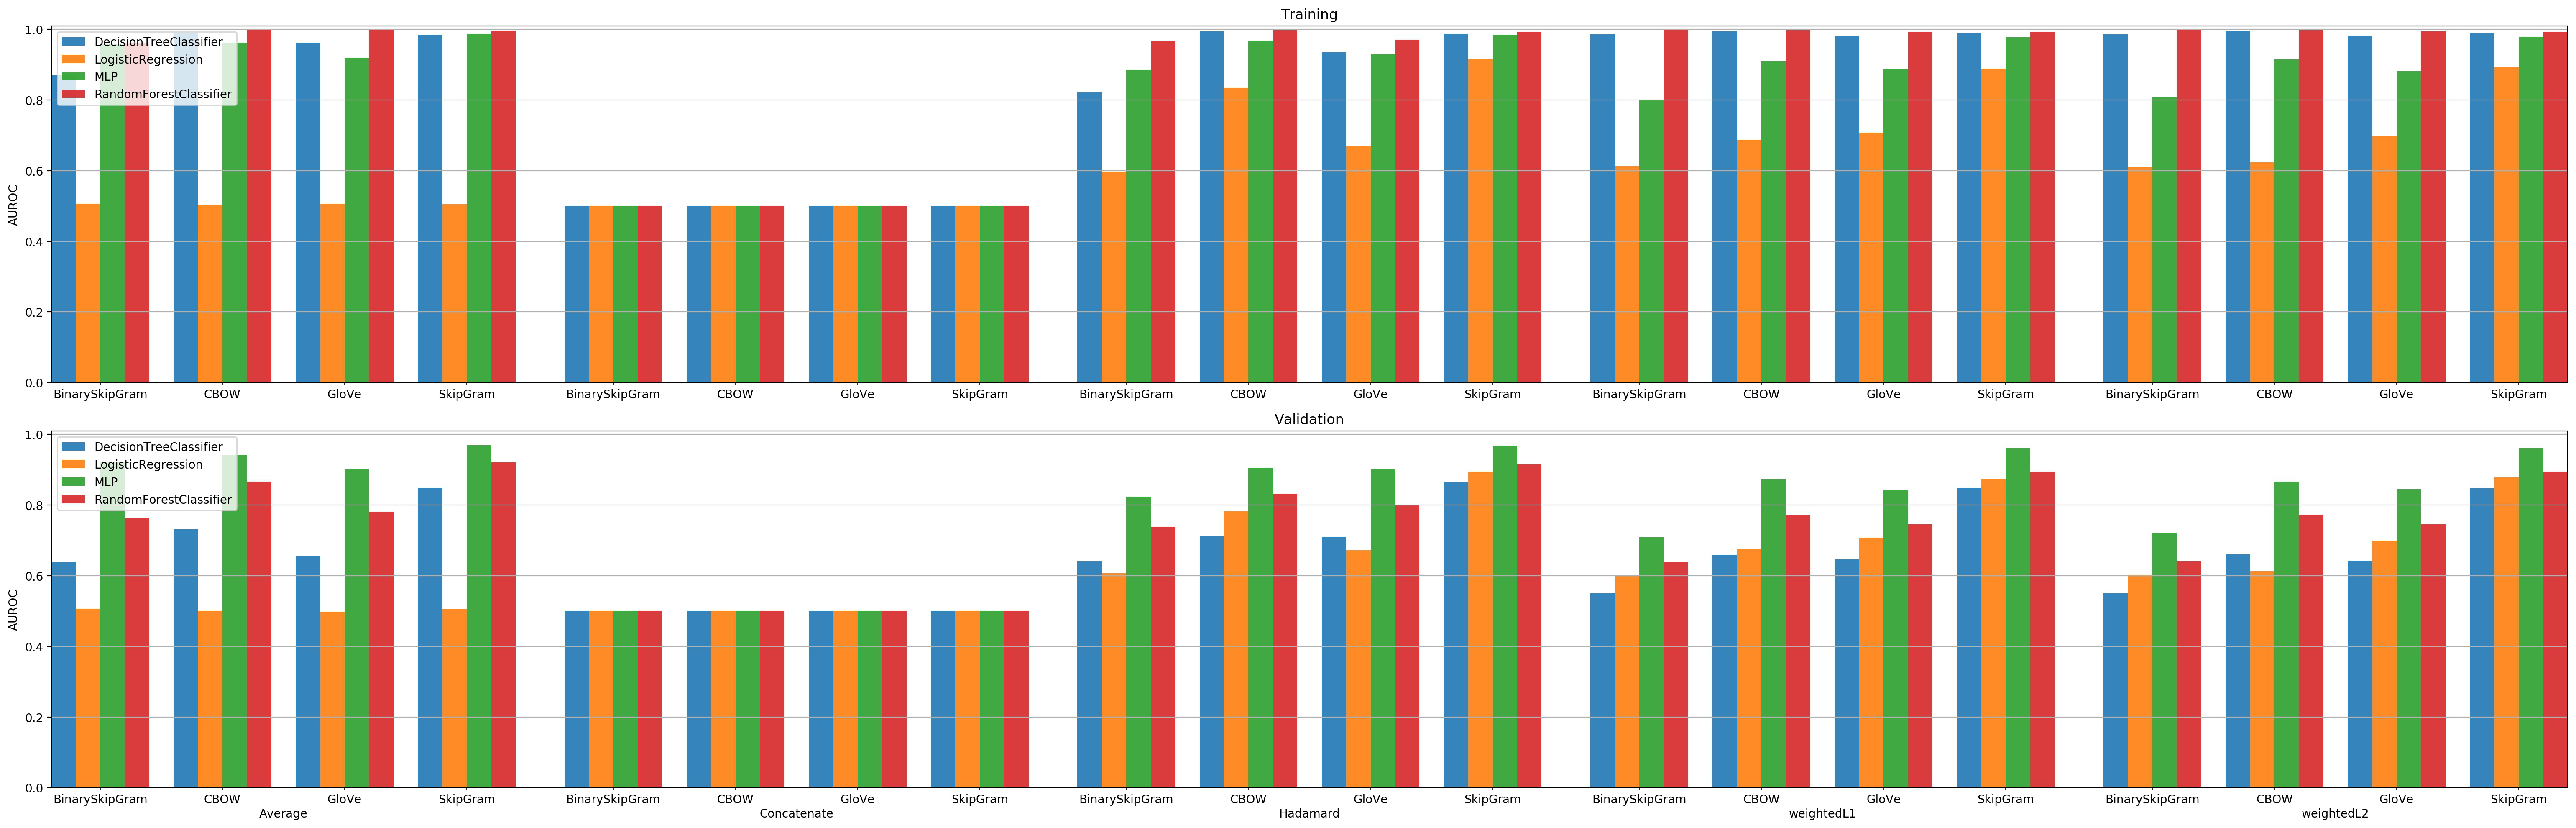

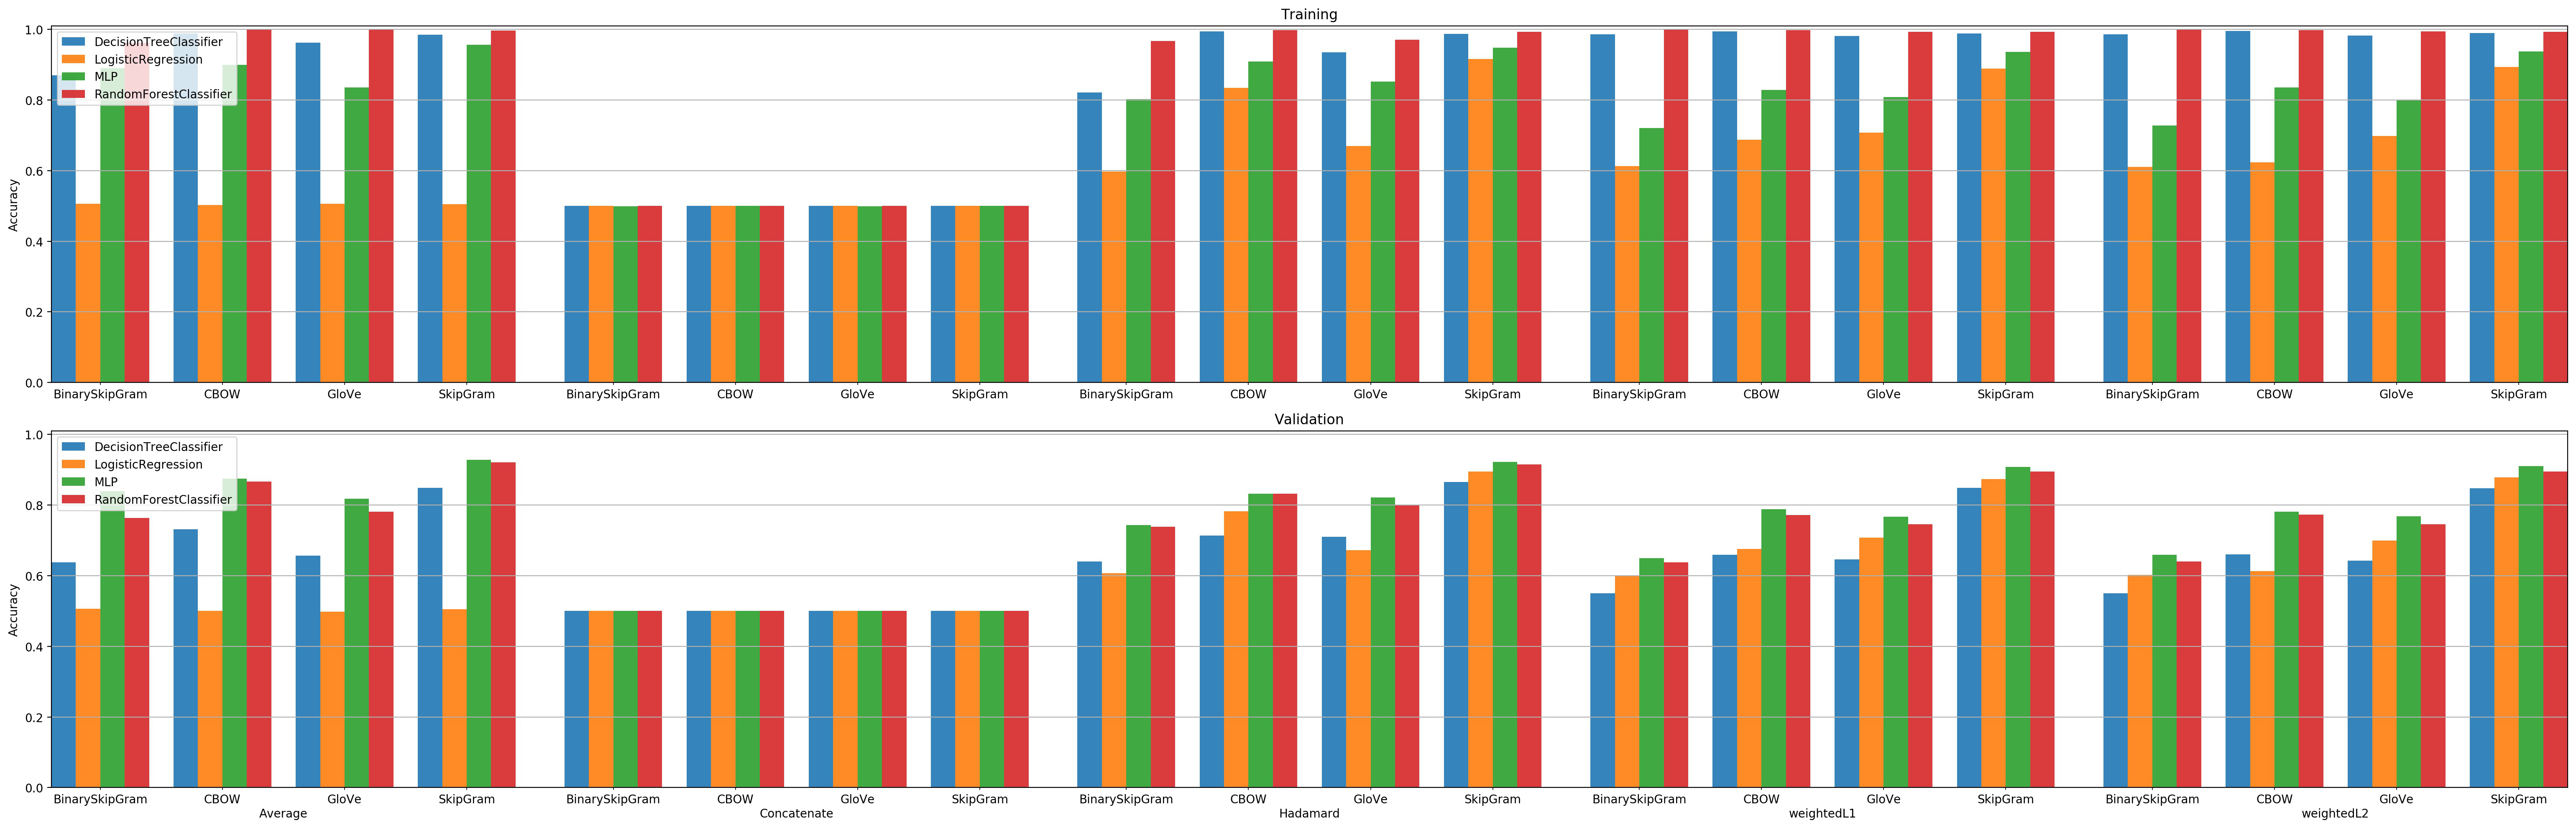

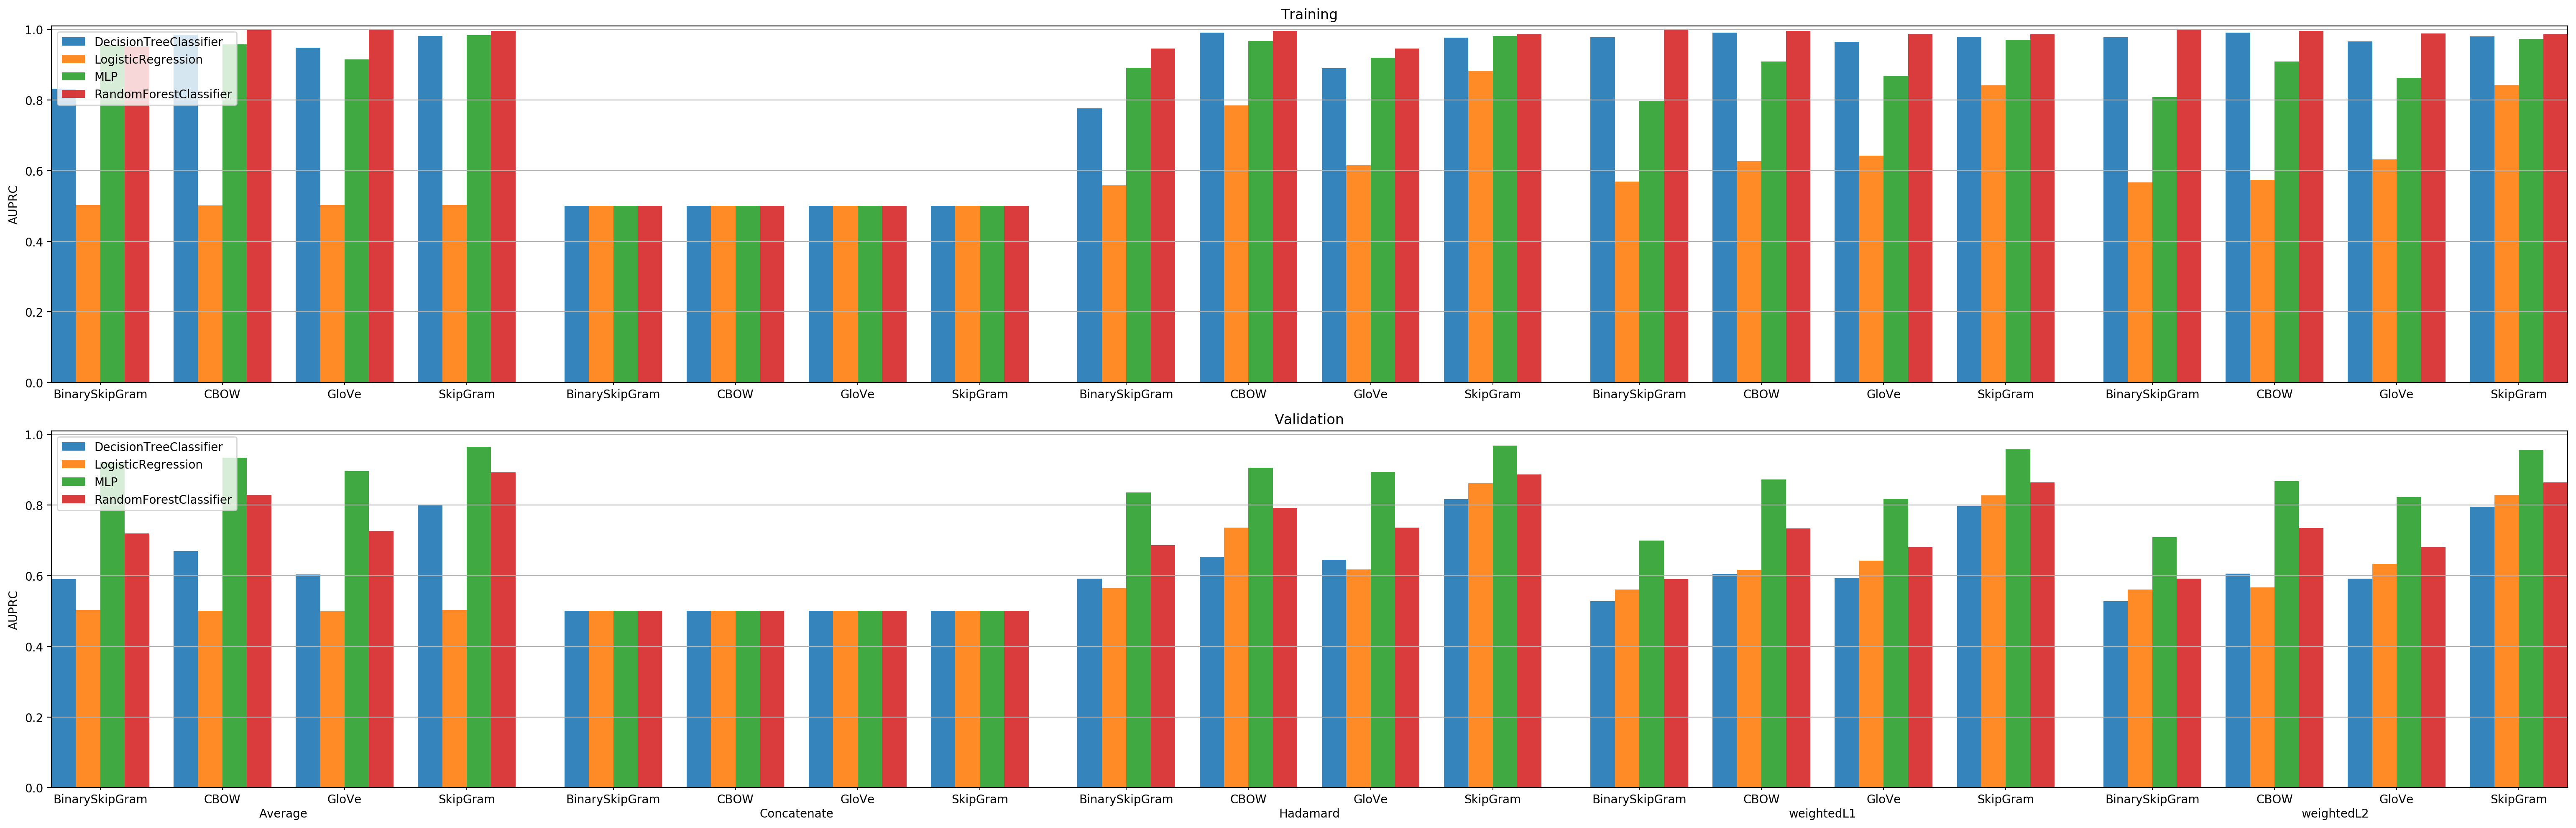

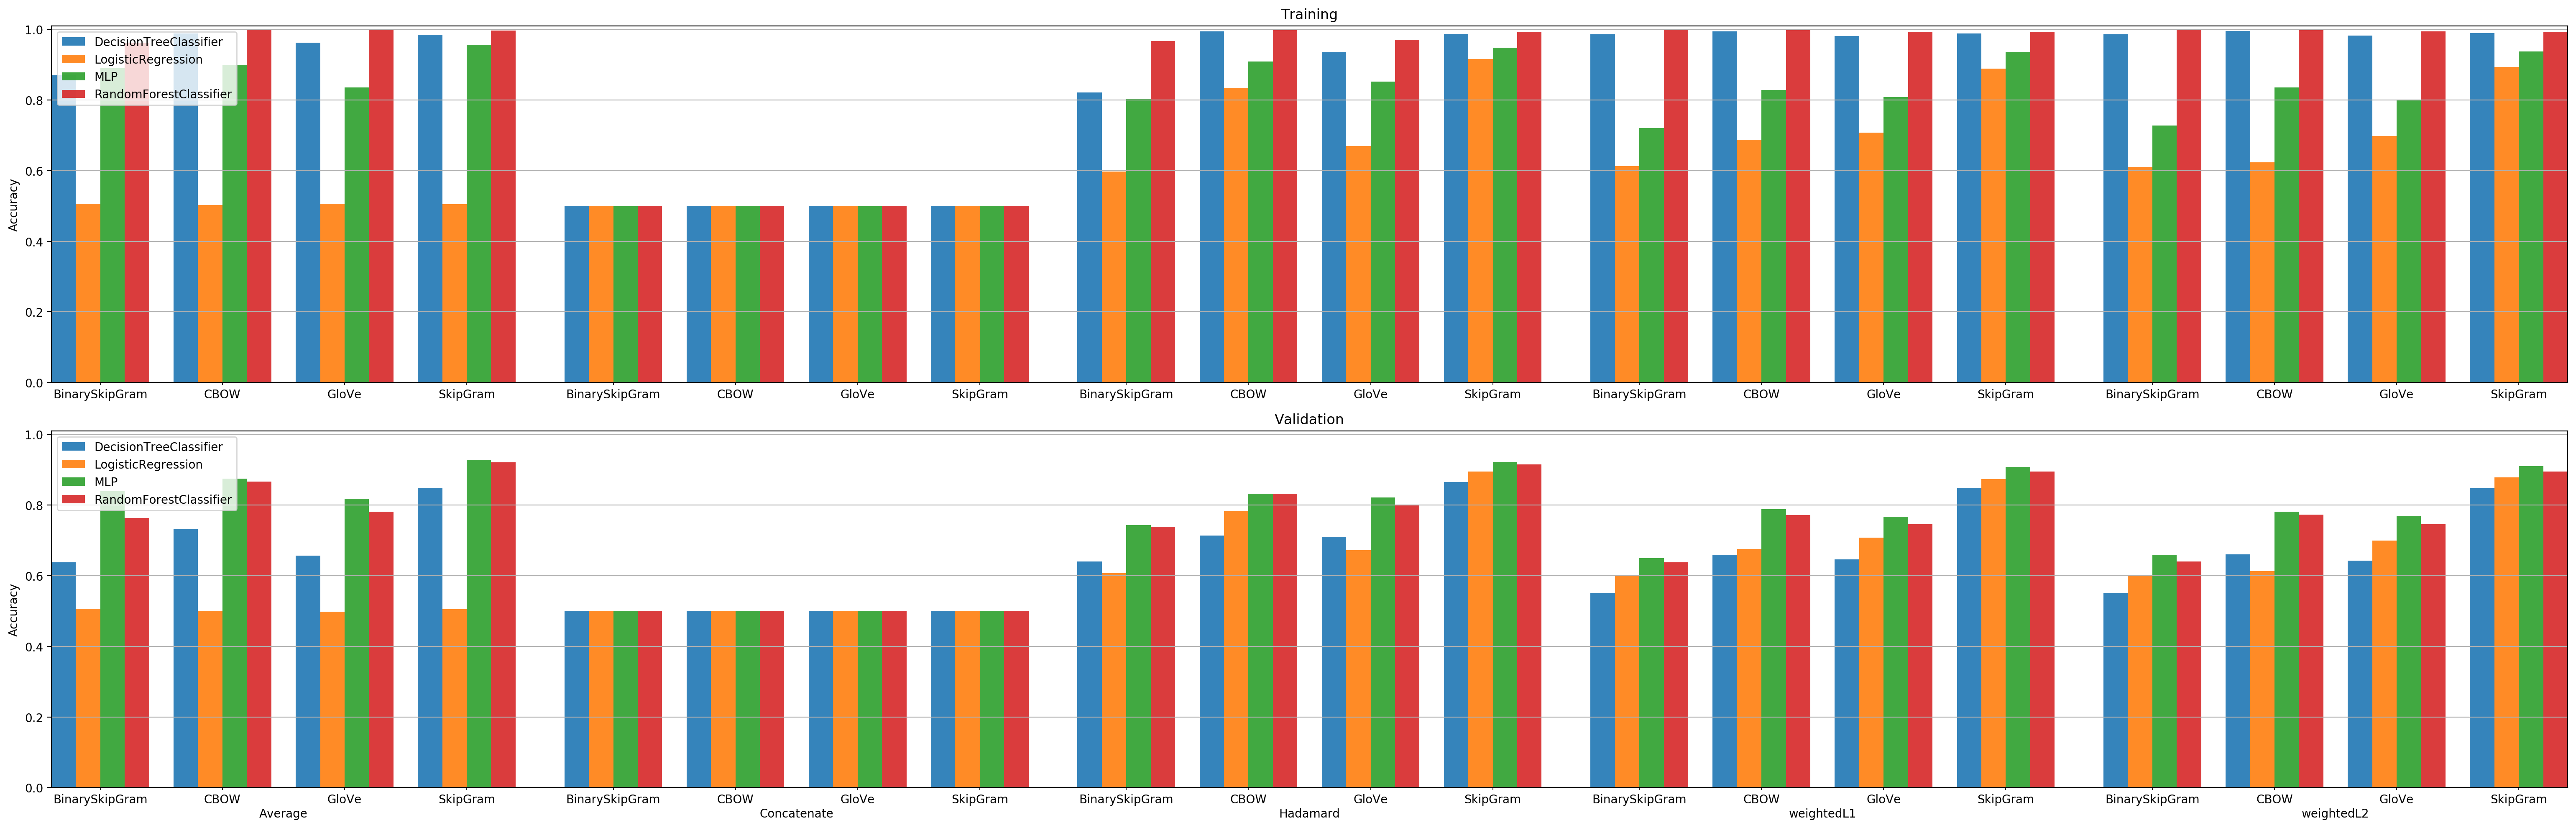

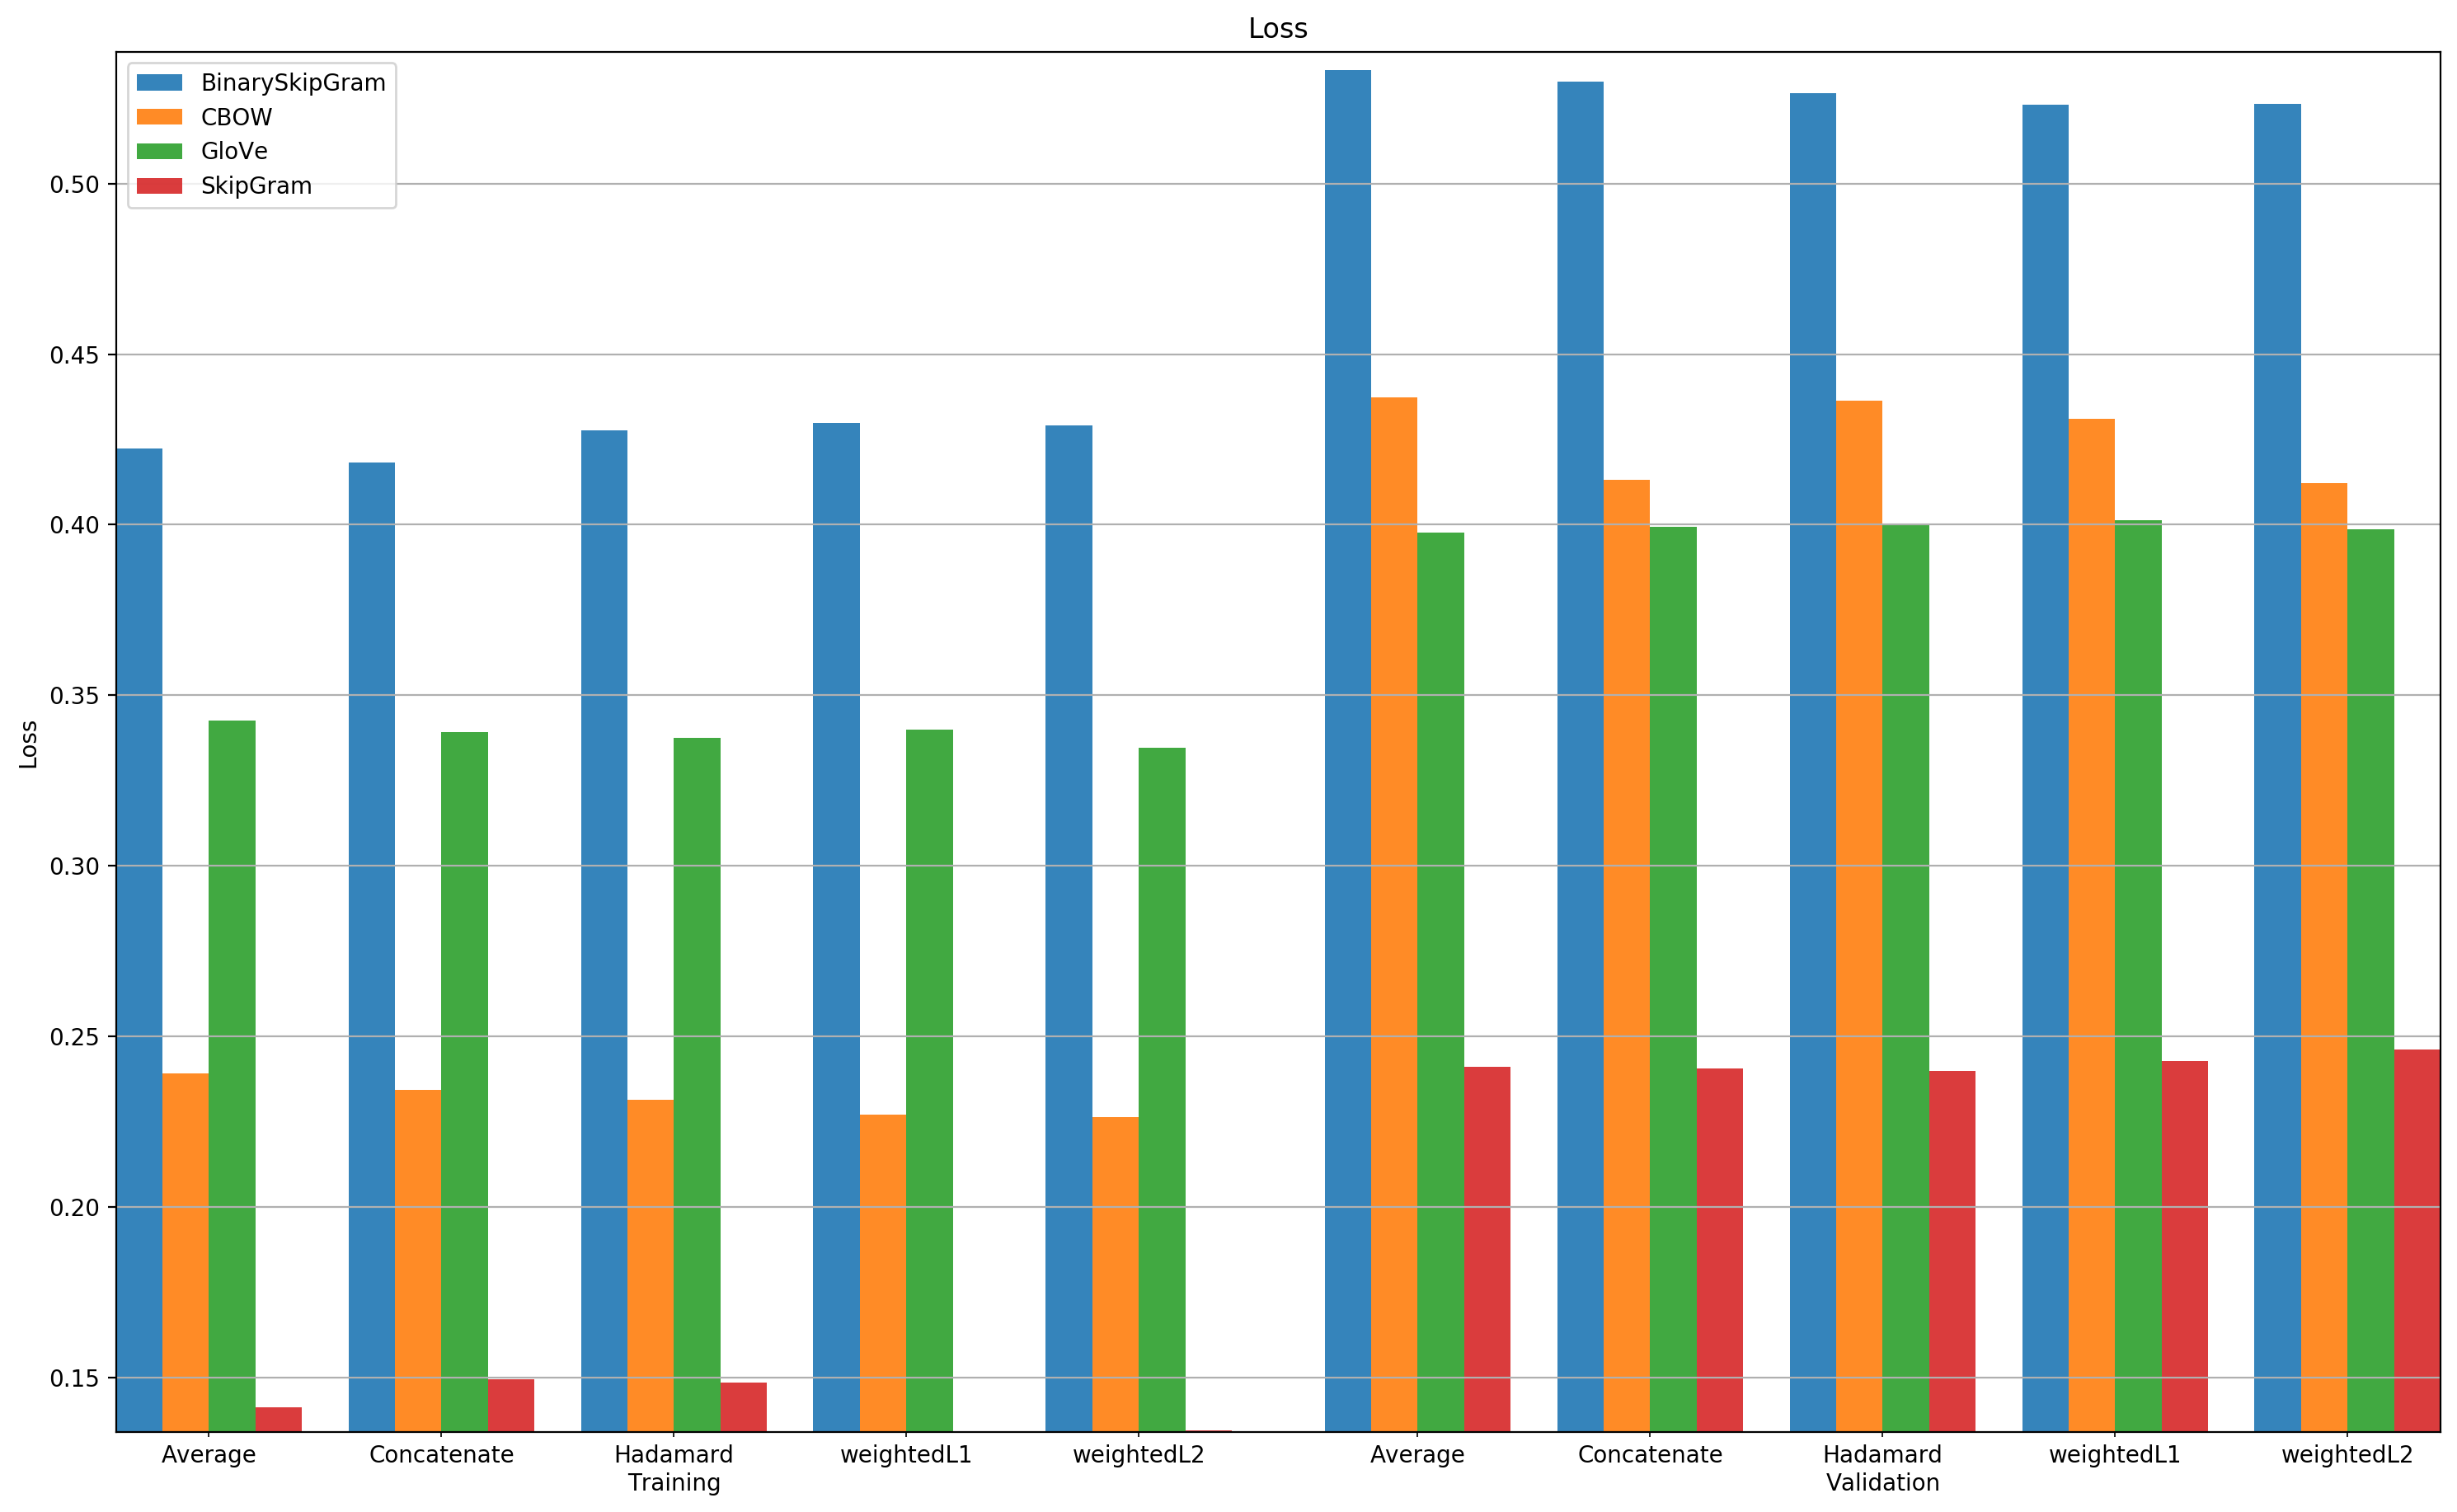

In [17]:
from barplots import barplots
from IPython.display import display
from PIL import Image

# show_standard_deviation is False because there is only one holdout!
barplots(
    all_reports,
    ["run", "method", "embedding_model", "model"],
    path = 'barplots/{feature}.jpg',
    show_standard_deviation=False,
    height=5,
    subplots=True,
    plots_per_row=1
)

for barplot_path in glob("barplots/*"):
    display(Image.open(barplot_path))

In [18]:
from scipy.stats import wilcoxon

scored_per_method = [
    (group, x["AUPRC"].values)
    for group, x in list(all_reports[["AUPRC", "method"]].groupby("method"))
]

for i, (method1, scores1) in enumerate(scored_per_method):
    for method2, scores2 in scored_per_method[i+1:]:
        print(
            method1, method2, wilcoxon(scores1, scores2)
        )

average concatenate WilcoxonResult(statistic=2.0, pvalue=9.626574784701925e-07)
average hadamard WilcoxonResult(statistic=220.0, pvalue=0.41064826930745923)
average weightedL1 WilcoxonResult(statistic=255.0, pvalue=0.8663547800600295)
average weightedL2 WilcoxonResult(statistic=247.0, pvalue=0.7505744646291802)
concatenate hadamard WilcoxonResult(statistic=0.0, pvalue=7.952884142692727e-07)
concatenate weightedL1 WilcoxonResult(statistic=0.0, pvalue=7.952884142692727e-07)
concatenate weightedL2 WilcoxonResult(statistic=0.0, pvalue=7.952884142692727e-07)
hadamard weightedL1 WilcoxonResult(statistic=130.0, pvalue=0.012222379999466314)
hadamard weightedL2 WilcoxonResult(statistic=124.0, pvalue=0.008848528462849805)
weightedL1 weightedL2 WilcoxonResult(statistic=246.0, pvalue=0.9687364427199858)
